# BE/Bi 103, Fall 2016: Homework 8
## Due 1pm, Sunday, November 20


(c) 2016 Justin Bois. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained therein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This homework was generated from an Jupyter notebook.  You can download the notebook [here](hw8_solutions.ipynb).*

In [1]:
import collections
import glob
import math
import os
import pickle

import numpy as np
import pandas as pd
import scipy.signal
import scipy.stats as st
import numba

# Image processing tools
import skimage
import skimage.io

import bebi103

import corner

import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)
%matplotlib inline

# Import Bokeh modules for interactive plotting
import bokeh
bokeh.io.output_notebook()

Loading BokehJS ...

### Problem 8.1: Pulsing jellyfish (60 pts)
In [Tutorial 8a](http://bebi103.caltech.edu/2016/protected/tutorials/t8a_extracting_info_from_images.html), we extracted information from movies of pulsing jellyfish. Using these images (which you can download [here](https://www.dropbox.com/s/mbz2gfnnwefdto2/cassiopea_pulsation.zip?dl=0)), analyze both the daytime and nighttime movies.  Compare and contrast the measurements both between daytime and nighttime and among the individual jellyfish.  Discuss any conclusions or suggestions for further experiments you may have.

*This question is intentionally open-ended. Think carefully about what you want to do and how you interpret what you see.*

### Problem 8.1: Solution

First things first, let's load the day and night images using the techniques we learned in Tutorial 8.

In [2]:
# The directory containing data
data_dir = '../data/Cassiopea_Pulsation/'

# Glob string for images
im_day_glob = os.path.join(data_dir, 'day', '*.TIF')
im_night_glob = os.path.join(data_dir, 'night', '*.TIF')

# Set up image collections
def squish_rgb(fname, img_num=None):
    return skimage.io.imread(fname)[:,:,0]

ic_day = skimage.io.ImageCollection(im_day_glob, conserve_memory=True, 
                                    load_func=squish_rgb)
ic_night = skimage.io.ImageCollection(im_night_glob, conserve_memory=True, 
                                      load_func=squish_rgb)

We first define the ROIs for the jellyfish.  Because the jellyfish do not move much (as verified by checking frames throughout the movie), I made the ROIs pretty tight around the jellyfish to improve signal to noise.  I used `plt.ginput()` to get vertices for ROIs for each of the eight jellyfish for day and nice.  I stored the result in a list and then pickled the result.  We'll load in the vertices, and then convert them to ROIs.

In [3]:
# Load vertices
with open('verts_day.pkl', 'rb') as f:
    verts_day = pickle.load(f)
    
with open('verts_night.pkl', 'rb') as f:
    verts_night = pickle.load(f)
    
# Convert vertices to ROIs
roi_day = [None] * 8
roi_night = [None] * 8
for i in range(8):
    roi_day[i], _, _ = bebi103.verts_to_roi(verts_day[i], *ic_day[0].shape)
    roi_night[i], _, _ = bebi103.verts_to_roi(verts_night[i], *ic_night[0].shape)

Now that we have our ROIs, let's look at them to make sure they make sense.

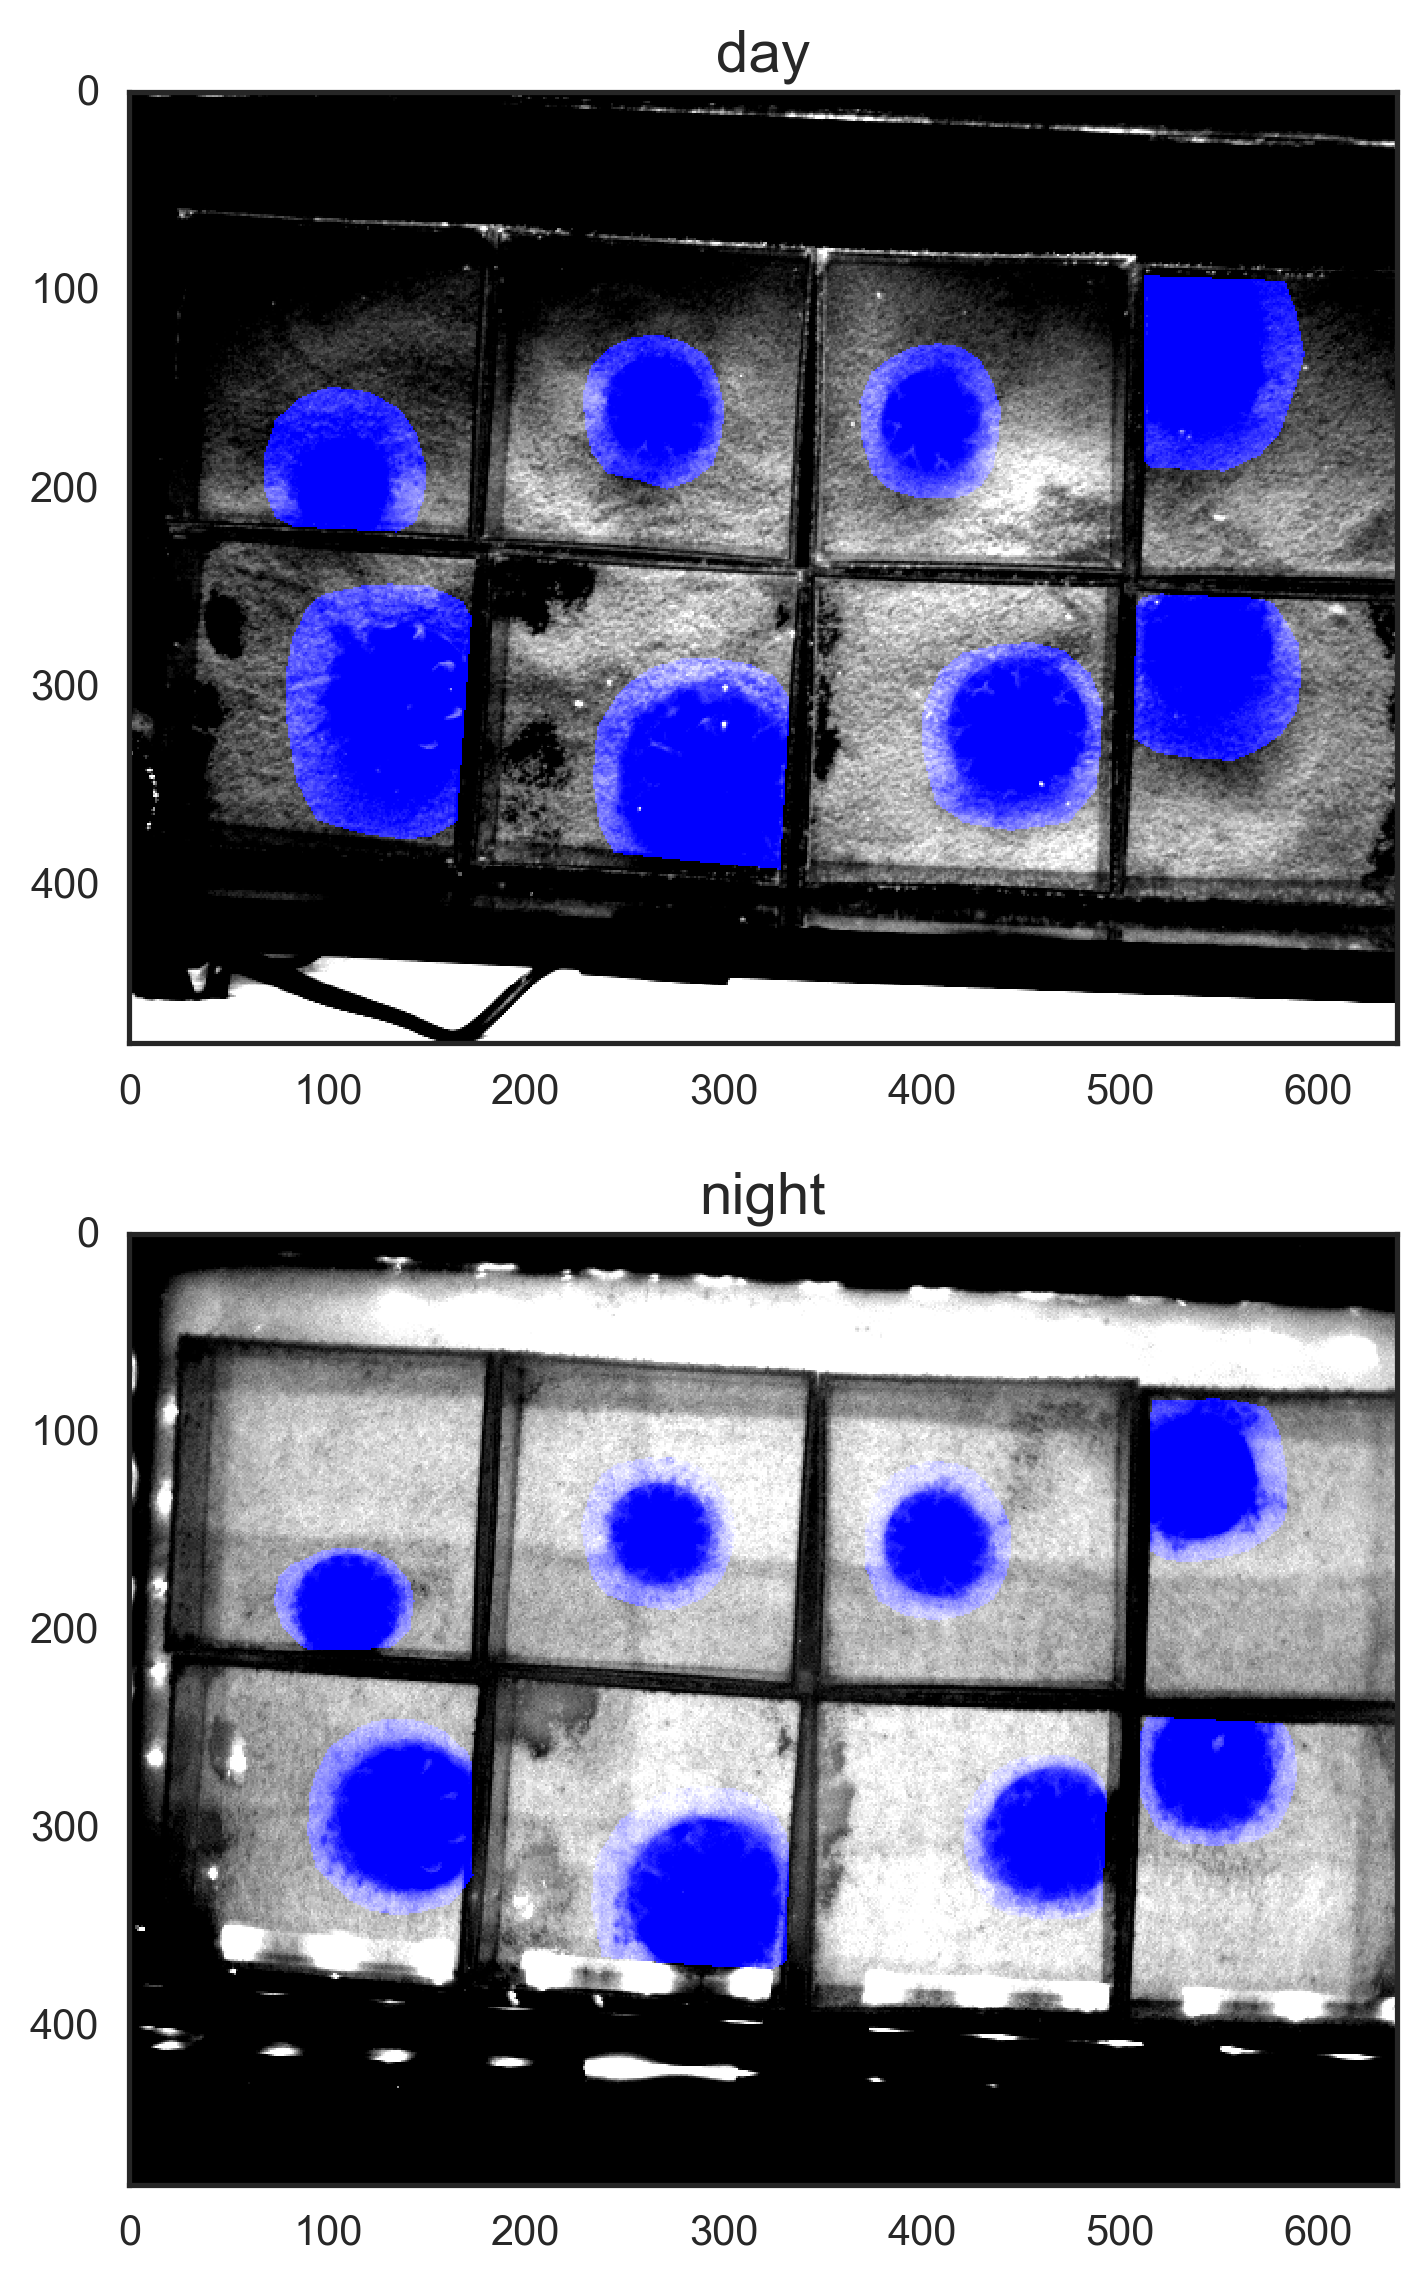

In [4]:
# Make grayscale image that is now RGB
im_day = np.dstack(3*[skimage.img_as_float(ic_day[0])])
im_night = np.dstack(3*[skimage.img_as_float(ic_night[0])])

# Max out blue channel
for roi in roi_day:
    im_day[roi,2] = skimage.dtype_limits(im_day)[1]
for roi in roi_night:
    im_night[roi,2] = skimage.dtype_limits(im_night)[1]
    
# Look at the images
with sns.axes_style('white'):
    fig, ax = plt.subplots(2, 1, figsize=(9, 9))
    ax[0].imshow(im_day)
    ax[1].imshow(im_night)
    ax[0].set_title('day')
    ax[1].set_title('night')

Looks pretty good!  Now, let's loop through the images and get the mean intensity over each ROI.  This will take a few minutes to run.

In [5]:
# Time points (using fact that images were 15 fps)
t_day = np.arange(len(ic_day)) / 15.0
t_night = np.arange(len(ic_night)) / 15.0

# Columns of DataFrames
cols = ['jf_' + str(i) for i in range(8)]

# Extract daytime data
mean_int_array = np.empty((len(ic_day), 8))
for i, im in enumerate(ic_day):
    for j, roi in enumerate(roi_day):
        mean_int_array[i,j] = im[roi].mean()
df_day = pd.DataFrame(columns=cols, data=mean_int_array) 
df_day['t'] = t_day

# Extract nighttime data
mean_int_array = np.empty((len(ic_night), 8))
for i, im in enumerate(ic_night):
    for j, roi in enumerate(roi_night):
        mean_int_array[i,j] = im[roi].mean()
df_night = pd.DataFrame(columns=cols, data=mean_int_array) 
df_night['t'] = t_night

/Users/Justin/anaconda/lib/python3.5/site-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


Let's now plot the traces.  It is most useful to do it using Bokeh so we can zoom in and out.  This is pretty slick: I make a tabbed set of plots, so we can switch from one jellyfish to the next.  Night and day are plotted with each other.  If we zoom in the time axis of one plot, it is linked to the other.

In [6]:
# Set up tabs and plots
tabs = [None] * 8
vplots = [None] * 8

# Populate the tabs
for i, jf in enumerate(cols):
    # Create figures
    plots = [bokeh.plotting.figure(plot_width=600, plot_height=250) 
                for j in range(2)] 
    plots[1].xaxis.axis_label = 'time (s)'
    plots[0].yaxis.axis_label = 'day mean int.'
    plots[1].yaxis.axis_label = 'night mean int.'
    
    # Link ranges (enable linked zooming of time axis)
    plots[1].x_range = plots[0].x_range
    
    # Add glyphs
    plots[0].line(x=df_day.t, y=df_day[jf], color='dodgerblue')
    plots[1].line(x=df_night.t, y=df_night[jf], color='darkslateblue')

    # Construct vertical plots
    vplots[i] = bokeh.io.gridplot([[plots[0]], [plots[1]]], 
                                  toolbar_location='right')
    
    # Put in tab
    tabs[i] = bokeh.models.widgets.Panel(child=vplots[i], title=jf)

# Assemble and show tabs
tabs = bokeh.models.widgets.Tabs(tabs=tabs)
bokeh.io.show(tabs)

As we tab through the jellyfish, each one shows qualitatively different pulsing behavior at night versus during the day.  In particular, the night time traces show long pauses without contraction.  Let's quantify this by computing the inter-contraction times for each jellyfish for day and night. A contraction occurs when the intensity in the ROI reaches a maximum (the jellyfish is more compact).

Our strategy is as follows.
1. Subtract the mean and rescale the data so they go from -1 to 1.
2. Identify peak regions as between positive and negative crossings of zero.
3. Localize the maximum of the peak as the maximum between upward and downward crossings of zero.
4. Get sub-sampling accuracy for peak placement by fitting a quadratic to the maximum point and its nearest neighbors, like we did in [Tutorial 8a](http://bebi103.caltech.edu/2016/tutorials/t8a_time_series.html).

We first write a quick function to use the quadratic fitting method to get a local maximum.

In [7]:
def local_min(x, y):
    """
    Fit three points to quadratic and return x, y coords of max or min.
    """
    a, b, c = np.polyfit(x, y, 2)
    x_max = -b / 2 / a
    return x_max, a*x_max**2 + b*x_max + c

Now, we can write our function to find the peak maxima.

In [8]:
def peak_maxima(t, mean_int):
    """
    Find the time points where peaks of mean intensity are reached.
    
    IMPORTANT: Because this uses indexing, t and mean_int must be
    NumPy arrays, not DataFrames!
    """
    # Do background subtraction and rescaling
    mean_int -= mean_int.mean()
    mean_int = 1 + 2 / (mean_int.max() - mean_int.min()) \
                    * (mean_int - mean_int.max())
    
    # Find up and down crossing indices
    up_crossing_inds = np.where(
        np.logical_and(mean_int[:-1] < 0, mean_int[1:] >= 0))[0]
    down_crossing_inds = np.where(
        np.logical_and(mean_int[:-1] > 0, mean_int[1:] <= 0))[0] + 1

    # Make sure upcrossing are first
    if down_crossing_inds[0] < up_crossing_inds[0]:
        down_crossing_inds = down_crossing_inds[1:]

    # Make sure downcrossing last
    if up_crossing_inds[-1] > down_crossing_inds[-1]:
        up_crossing_inds = up_crossing_inds[:-1]
        
    # Find maxima
    t_peaks = np.empty(len(up_crossing_inds))
    for i, uc in enumerate(up_crossing_inds):
        ind = uc + np.argmax(mean_int[uc:down_crossing_inds[i]+1])
        t_peaks[i], _ = local_min(t[ind-1:ind+2], mean_int[ind-1:ind+2])
        
    return t_peaks

Now, we'll compute the time that the contractions occur and store them in a `DataFrame`.

In [9]:
df_peaks = pd.DataFrame(columns=['jf', 'night_or_day', 'time_of_peak'])
for night_or_day in ['day', 'night']:
    if night_or_day == 'day':
        df_ = df_day
    else:
        df_ = df_night
    for i, jf in enumerate(cols):
        df_tmp = pd.DataFrame(columns=df_peaks.columns)
        df_tmp['time_of_peak'] = peak_maxima(df_.t.values, df_[jf].values)
        df_tmp['jf'] = [jf] * len(df_tmp['time_of_peak'])
        df_tmp['night_or_day'] = [night_or_day] * len(df_tmp['time_of_peak'])
        df_peaks = pd.concat((df_peaks, df_tmp), axis=0, ignore_index=True)

Now, we can compute the ECDFs for each jellyfish for night and day.

In [10]:
# Set up tabs and plots
tabs = [None] * 8

# Populate the tabs
for i, jf in enumerate(cols):
    # Create figures
    p = bokeh.plotting.figure(plot_width=650, plot_height=350, 
                              x_axis_label='intercontraction time (s)',
                              y_axis_label='ECDF')
      
    # Day ECDF
    df_inds = (df_peaks.jf == jf) & (df_peaks.night_or_day == 'day')
    t_int = np.diff(df_peaks[df_inds]['time_of_peak'].values)
    x = np.sort(t_int)
    y = np.arange(1, len(x)+1) / len(x)
    p.circle(x, y, color='dodgerblue', legend='day')

    # Night ECDF
    df_inds = (df_peaks.jf == jf) & (df_peaks.night_or_day == 'night')
    t_int = np.diff(df_peaks[df_inds]['time_of_peak'].values)
    x = np.sort(t_int)
    y = np.arange(1, len(x)+1) / len(x)
    p.circle(x, y, color='darkslateblue', legend='night')
    
    p.legend.location = 'bottom_right'
        
    # Put in tab
    tabs[i] = bokeh.models.widgets.Panel(child=p, title=jf)

# Assemble and show tabs
tabs = bokeh.models.widgets.Tabs(tabs=tabs)
bokeh.io.show(tabs)

From the ECDFs, we see significant variability from jellyfish to jellyfish.  Jellyfish 0 and Jellyfish 4 have nighttime pulse frequencies similar to those that they have in the daytime.  The rest of the jellyfish have decidedly slower pulse rates.  With the exception of jellyfish 3, all jellyfish exhibit longer and more frequent pauses at nighttime as opposed to daytime.  Jellyfish 4 has some *very* long pauses at night.  Jellyfish 5 pauses a lot, both during the day and at night, with longer pauses at night.

It is hard to make solid conclusion from these data, but the long pauses at nighttime are unmistakable and indicative of a restful state.

In [50]:
df_inds = (df_peaks.jf == 'jf_1') & (df_peaks.night_or_day == 'night')
t = np.diff(df_peaks[df_inds]['time_of_peak'].values)

In [51]:
@numba.jit(nopython=True)
def logsumexp(x, w):
    """
    Return np.log(np.sum(w * np.exp(x))).
    """
    x_max = x.max()
    return x_max + np.log(np.sum(w * np.exp(x - x_max)))
    

@numba.jit(nopython=True)
def log_like(p, t_vals):
    tau0, tau1, tau2, sigma = p
    log_like_sum = 0

    a = sigma**2 / 2 / tau1**2 - tau0 / tau1
    if np.abs(tau1 - tau2) < 1e-9:
        for t in t_vals:
            w = np.array([1/np.sqrt(2*np.pi)/sigma, t/tau1**2, -t/tau1**2])
            x = np.array([a - (t-tau0)**2 / 2 / sigma**2, 
                          -t/tau1, 
                          a - t/tau1])
            log_like_sum += logsumexp(x, w)
    else:
        b = 1 / (tau2 - tau1)
        w = np.array([1/np.sqrt(2*np.pi)/sigma, 1, 1])
        for t in t_vals:
            x = np.array([a - (t-tau0)**2 / 2 / sigma**2, 
                          -t/tau2, 
                          -t/tau1,
                          a - t/tau2, 
                          a - t/tau1])
            log_like_sum += logsumexp(x, w)

    return log_like_sum


@numba.jit(nopython=True)
def log_prior(p):
    if (p <= 0).any():
        return -np.inf
    tau0, tau1, tau2, sigma = p
    
    if sigma**2 > 2 * tau0 * tau1:
        return -np.inf

    return -np.log(tau1) - np.log(tau2) - np.log(sigma)


@numba.jit(nopython=True)
def log_post(p, t):
    lp = log_prior(p)
    if lp == -np.inf:
        return -np.inf
    return lp + log_like(p, t)

In [54]:
# Set initial positions of walkers
n_walkers = 50

p_dict = collections.OrderedDict(
        [('tau0', (np.random.uniform, (1, 2))),
         ('tau1', (np.random.uniform, (5, 20))),
         ('tau2', (np.random.uniform, (5, 20))),
         ('sigma', (np.random.uniform, (0.05, 0.4)))])

# Perform MCMC
n_burn = 50000
n_steps = 50000
df_mcmc = bebi103.run_ensemble_emcee(
    log_post, n_burn, n_steps, n_walkers=n_walkers, p_dict=p_dict, args=(t,))

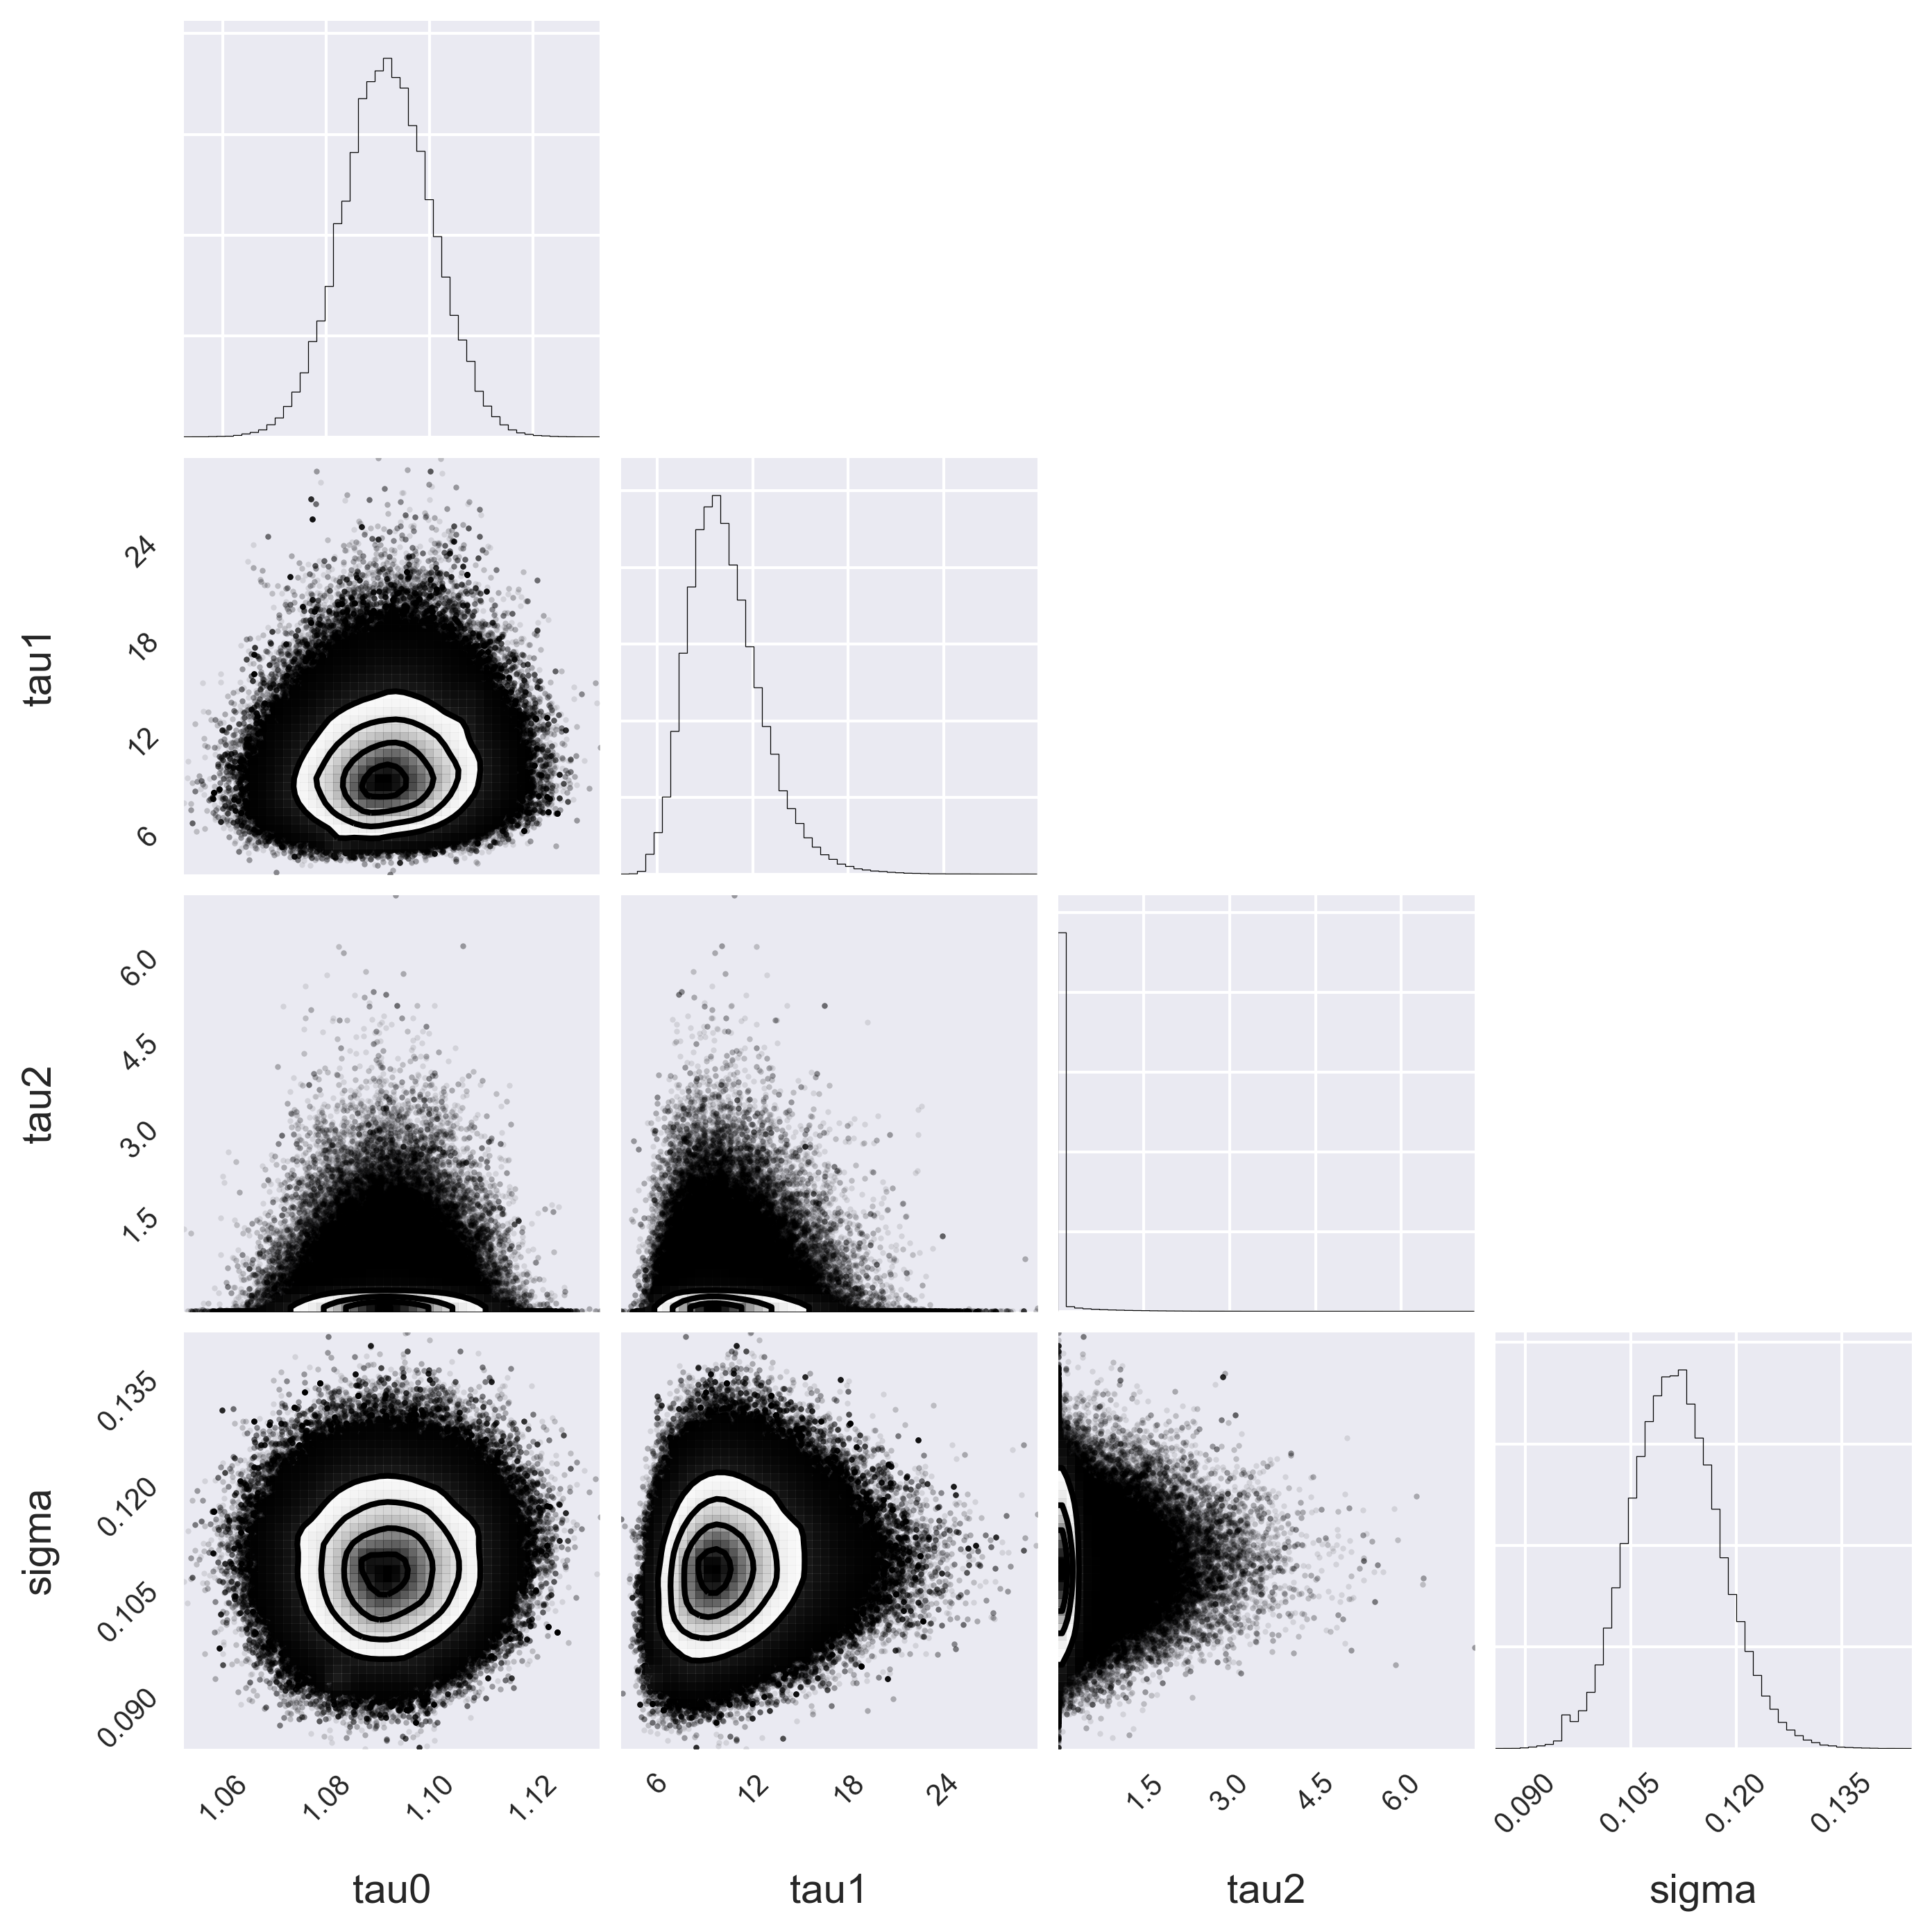

In [55]:
corner.corner(df_mcmc[['tau0', 'tau1', 'tau2', 'sigma']], bins=50, smooth=1);

In [48]:
len(df_mcmc)

1000000

<br />

### Problem 8.2: Analysis of FRAP data (40 pts + 10 pts extra credit)

With your new image processing skills, you can start to work on more complicated images.  For this problem, you will analyze a FRAP experiment and then perform parameter estimation to determine a diffusion coefficient and a binding rate for two molecules.  We will be taking a simplified approach, but there is more sophisticated analysis we can do to get better estimates for the phenomenological coefficients.

The data set comes from [Nate Goehring](https://goehringlab.crick.ac.uk).  The images are taken of a *C. elegans* one-cell embryo expressing a GFP fusion to the PH domain of Protein Lipase C delta 1 (PH-PLCd1).  This domain binds PIP2, a lipid enriched in the plasma membrane.  By using FRAP, we can investigate the dynamics of diffusion of the PH-PLCd1/PIP2 complex on the cell membrane, as well as the binding/unbinding dynamics of PH-PLCd1.

So, if $c$ is the concentration of the PH-PLDd1/PIP2 complex on the membrane and $c_\mathrm{cyto}$ is the concentration of PH-PLCd1 in the cytoplasm (assumed to be spatially uniform since diffusion in the cytoplasm is very fast), the dynamics are described by a reaction-diffusion equation.

\begin{align}
\frac{\partial c}{\partial t} = D\left(\frac{\partial^2 c}{\partial x^2} + \frac{\partial^2 c}{\partial y^2}\right) + k_\mathrm{on} c_\mathrm{cyto} - k_\mathrm{off} c.
\end{align}

Here, $k_\mathrm{on}$ and $k_\mathrm{off}$ are the phenomenological rate constants for binding and unbinding to PIP2 on the membrane, and $D$ is the diffusion coefficient for the PH-PLCd1/PIP2 complex on the membrane.

In [their paper](http://bebi103.caltech.edu/2015/protected/papers/goehring_2010.pdf), the authors discuss techniques for analyzing the data taking into account the fluorescence recovery of the bleached region in time and space.  For simplicity here, we will only consider recovery of the normalized mean fluorescence.  If $I(t)$ is the mean fluorescence of the bleached region and $I_0$ is the mean fluorescence of the bleached region immediately before photobleaching, we have, as derived in the paper,

\begin{align}
I_\mathrm{norm}(t) \equiv \frac{I(t)}{I_0} &= 
1 - f_b\,\frac{4 \mathrm{e}^{-k_\mathrm{off}t}}{d_x d_y}\,\psi_x(t)\,\psi_y(t),\\[1mm]
\text{where } \psi_i(t) &= \frac{d_i}{2}\,\mathrm{erf}\left(\frac{d_i}{\sqrt{4Dt}}\right)
-\sqrt{\frac{D t}{\pi}}\left(1 - \mathrm{e}^{-d_i^2/4Dt}\right),
\end{align}

where $d_x$ and $d_y$ are the extent of the photobleached box in the $x$- and $y$-directions, $f_b$ is the fraction of fluorophores that were bleached, and $\mathrm{erf}(x)$ is the [error function](http://en.wikipedia.org/wiki/Error_function).  Note that this function is defined such that the photobleaching event occurs at time $t = 0$.

We measure $I(t)$, $I_0$, $d_x$, and $d_y$.  We can also measure $f_b$ as

\begin{align}
f_b \approx 1 - \frac{I(0^+)}{I_0},
\end{align}

though we will consider this a parameter to estimate.  In practice, the normalized fluorescent recovery does not go all the way to unity.  This is because the FRAP area is a significant portion of the membrane, and we have depleted fluorescent molecules.  We should thus adjust our equation to be

\begin{align}
I_\mathrm{norm}(t) \equiv \frac{I(t)}{I_0} &= 
f_f\left(1 - f_b\,\frac{4 \mathrm{e}^{-k_\mathrm{off}t}}{d_x d_y}\,\psi_x(t)\,\psi_y(t)\right),
\end{align}

where $f_f$ is the fraction of fluorescent species left.  So, we have four parameters to use in regression, the physical parameters of interest, $D$ and $k_\mathrm{off}$, and $f_f$ and $f_b$.

The FRAP images come in a **TIFF stack**, which is a single TIFF file containing multiple frames.  You can load these with the `skimage.io.ImageCollection` class.

In [31]:
# Load in TIFF stack
fname = '../data/goehring_FRAP_data/PH_138_A.tif'
ic = skimage.io.ImageCollection(fname, conserve_memory=False)

# How long is it?
print('There are {0:d} frames.'.format(len(ic)))

There are 149 frames.


**a)** Extract the mean normalized fluorescence versus time from each of the TIFF stacks for the experimental repeats.  Note that important information is contained in the associated README file.  You can download the data set [here](http://bebi103.caltech.edu/2016/protected/data/goehring_FRAP_data.zip).

**b)** Perform regressions to find $D$ and $k_\mathrm{off}$ for each.  Report your final estimates for $D$ and $k_\mathrm{off}$.

**c)** (10 pts extra credit) Repeat part (b) with a hierarchical model. (You will need Wednesday's lecture material to do this part of the problem.)

### Problem 8.2: solution
We will automatically load the images and determine the bleach area.  The bleach area is the 40x40 region of the image at the bleach frame with the lowest total intensity.  First, we'll specify some properties of the images.

In [41]:
# Information about the data
im_glob = '../data/goehring_FRAP_data/*.tif'
edge_length = 40
interpixel_distance = 0.138  # µm
dt = 0.188  # s
bleach_frame = 20

# Compute physical distances
dx = edge_length * interpixel_distance
dy = edge_length * interpixel_distance

# Get image files
im_files = glob.glob(im_glob)

Now, we write a function to find the bleach area.

In [42]:
def bleach_roi(im, edge_length):
    """
    Return slice object to pull out bleach area.
    
    There are much more efficient ways to do this, but since we only
    do it a few times on small images, this works fine.
    """
    # Initialize sum
    min_sum = edge_length**2 * im.max()

    # Find total intensity of all possible bleach areas
    for i in range(im.shape[0]-edge_length):
        for j in range(im.shape[1]-edge_length):
            subim_sum = im[i:i+edge_length,j:j+edge_length].sum()
            if subim_sum < min_sum:
                corner = (i, j)
                min_sum = subim_sum

    return np.s_[corner[0]:corner[0]+edge_length,
                 corner[1]:corner[1]+edge_length]

Let's get the bleach areas of all of the images.

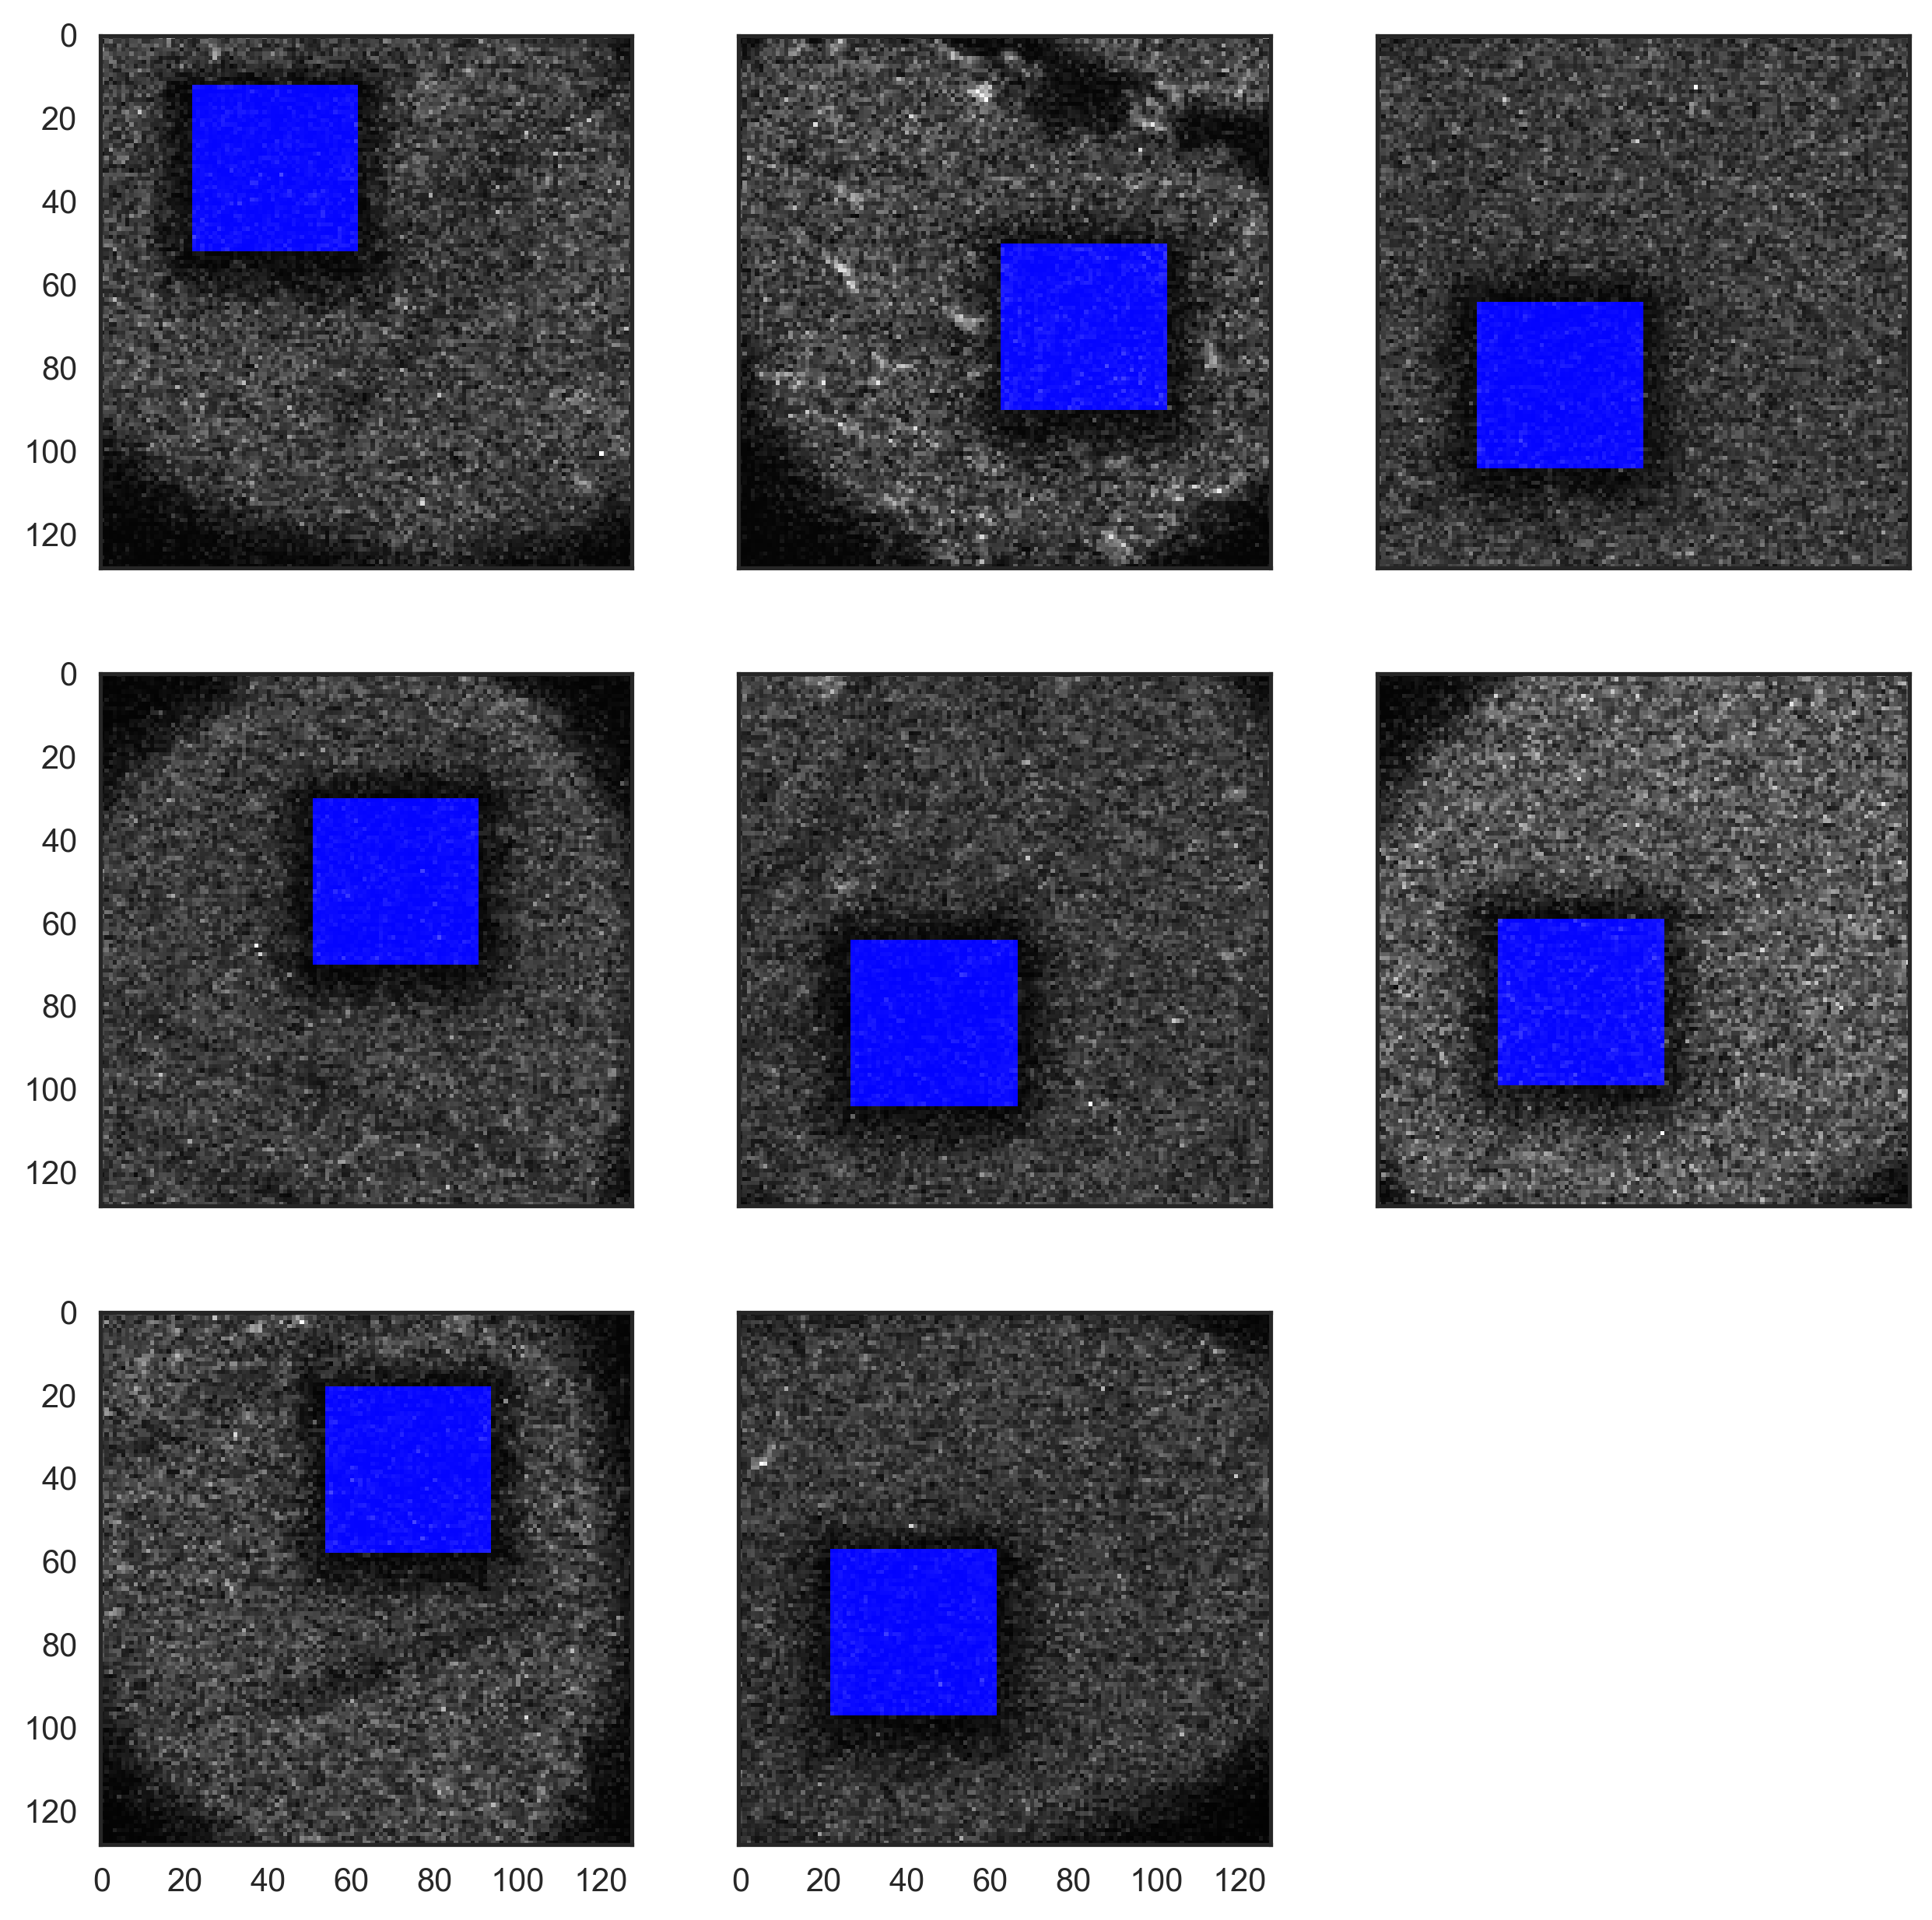

In [43]:
# Set up figure layout
with sns.axes_style('white'):
    fig, ax = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)

# Convenient indices to have around
inds = list(zip((0, 1, 2, 0, 1, 2, 0, 1, 2), (0, 0, 0, 1, 1, 1, 2, 2, 2)))

# Make each plot with FRAP area in red
for i, fname in enumerate(im_files):
    # Load image collection
    ic = skimage.io.ImageCollection(fname, conserve_memory=False)

    # Extract frame where bleach occured
    im_bleach = ic[bleach_frame]

    # Extract the ROI
    roi = bleach_roi(im_bleach, edge_length)

    # Look at bleach ROI to see if it makes sense.
    im_rgb = np.dstack([im_bleach / im_bleach.max()]*3)
    im_rgb[:,:,2][roi] = 1
    ax[inds[i]].imshow(im_rgb)

ax[inds[-1]].axis('off');

Looks pretty good.  Now, we'll loop through and compute the average intensity for each frame.  I don't really care that we're repeating work here; it is a fast calculation.

In [46]:
# Set up DataFrame
df = pd.DataFrame()

# Make each plot with FRAP area in red
for i, fname in enumerate(im_files):
    # Load image collection
    ic = skimage.io.ImageCollection(fname, conserve_memory=False)

    # Extract frame where bleach occured
    im_bleach = ic[bleach_frame]

    # Extract the ROI
    roi = bleach_roi(im_bleach, edge_length)

    # Compute average intensity
    mean_int = np.empty(len(ic))
    for j, im in enumerate(ic):
        mean_int[j] = im[roi].mean()
        
    # Put in DataFrame
    df['mean intensity trial ' + str(i)] = mean_int
    
# Add time points to DataFrame (zero is bleach frame)
df['time (s)'] = (np.arange(len(df)) - bleach_frame) * dt 

We created a `DataFrame` whose index is the frame number to store the traces.  Now, let's plot all of the curves together.

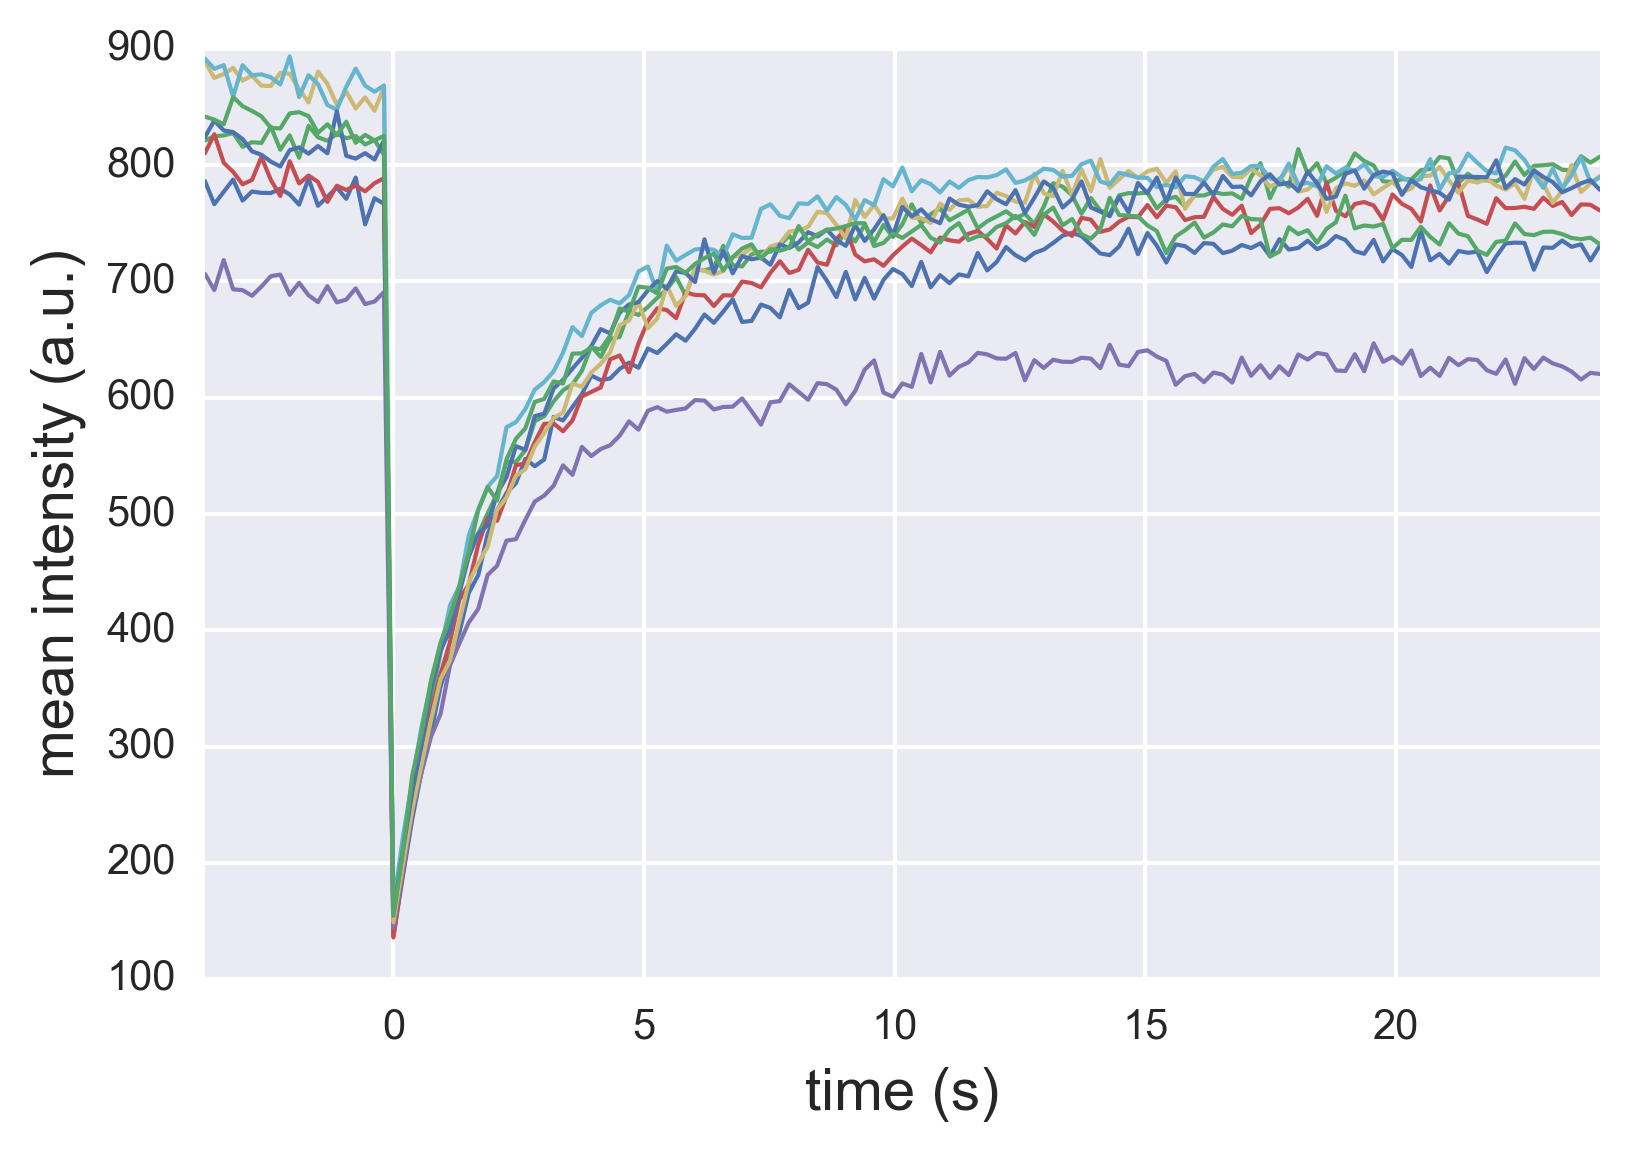

In [47]:
for col in df.columns[df.columns.str.contains('intensity')]:
    plt.plot(df['time (s)'], df[col], '-', lw=1)
plt.xlabel('time (s)')
plt.ylabel('mean intensity (a.u.)')
plt.margins(x=0)

Now, to normalize the fluorescence, we will take $I_0$ to be the mean of the first 20 measurements.

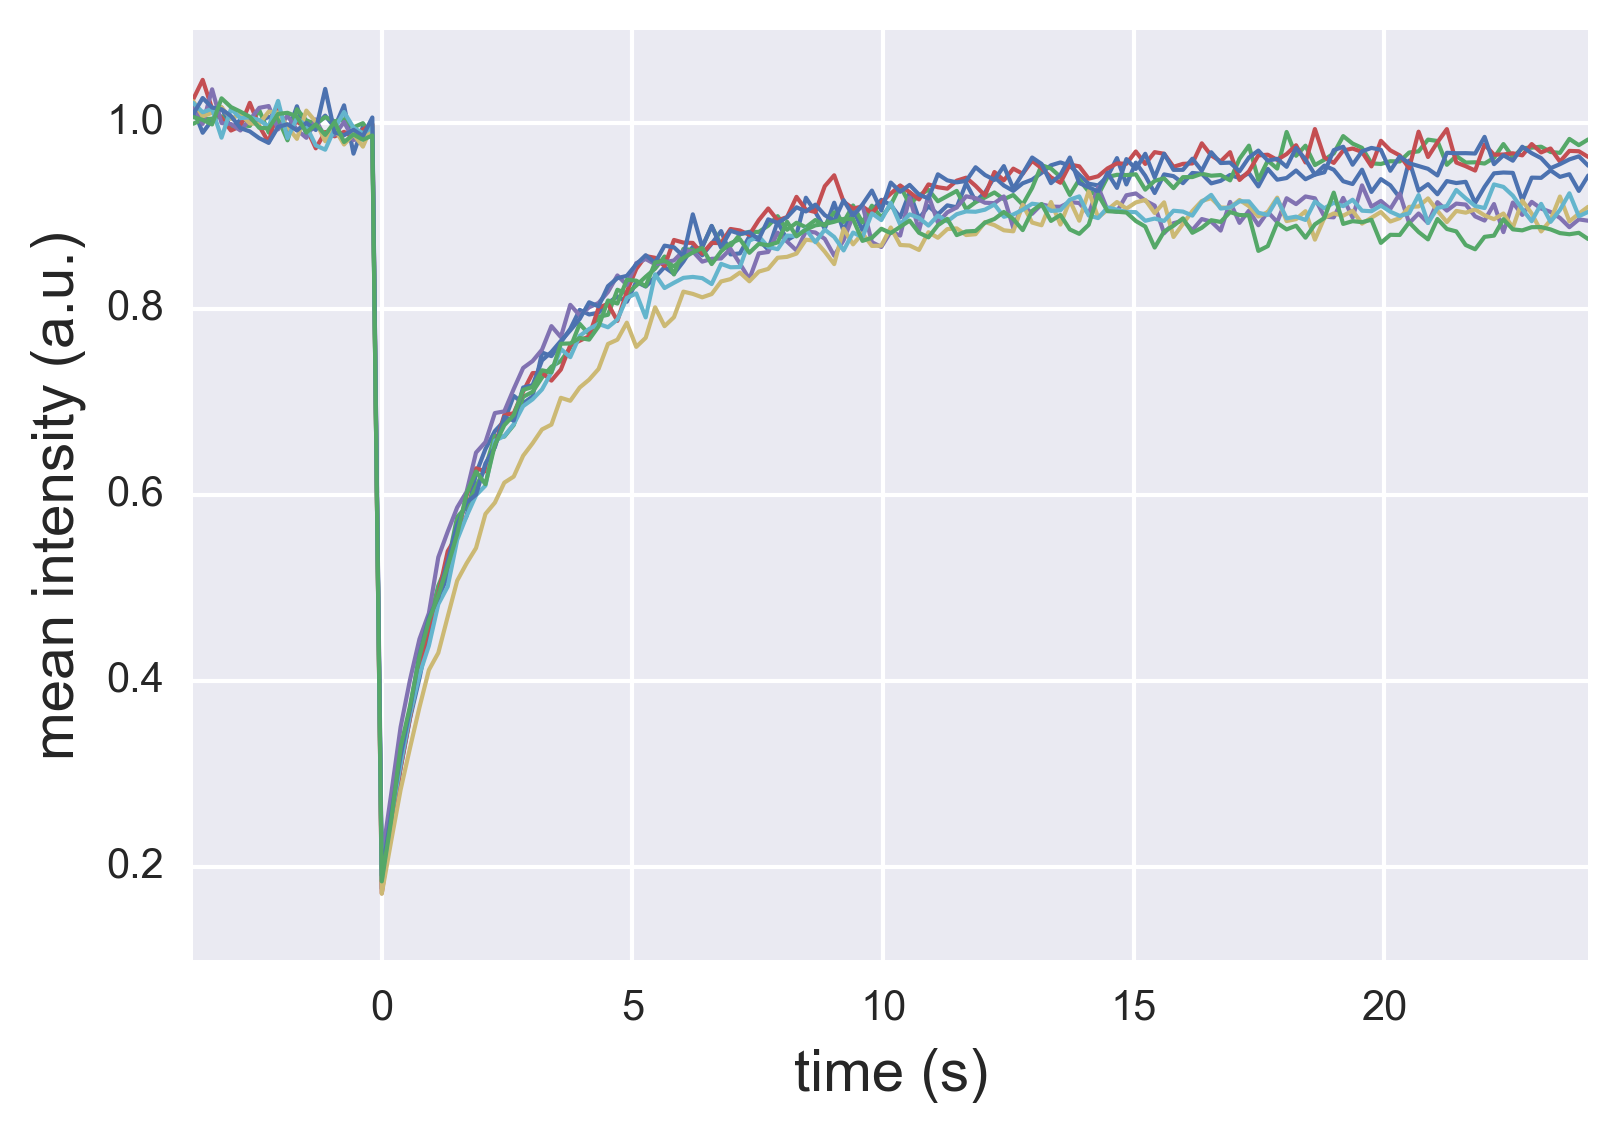

In [48]:
# Normalize intensities
for col in df.columns[df.columns.str.contains('intensity')]:
    I0 = df.loc[:bleach_frame-1, col].mean()
    df['normalized ' + col] = df[col] / I0
    
# Plot normalized curves
for col in df.columns[df.columns.str.contains('normalized')]:
    plt.plot(df['time (s)'], df[col], '-', lw=1)
plt.xlabel('time (s)')
plt.ylabel('mean intensity (a.u.)')
plt.margins(x=0)

**b)** Now that we have normalized fluorescence, we can perform regressions.  We just need to specify our theoretical model and the log posterior.  We will assume that the FRAP recovery follows the theoretical curve with Gaussian errors characterized by a parameter $\sigma$.  We use a marginalized posterior (with $\sigma$ marginalized out) to perform the regression.  As a reminder, the marginalized posterior is

\begin{align}
\ln P(D, k_\mathrm{off}, f_b, f_f\mid \{t,I\}, I) =\text{constant} -\frac{n}{2}\,
\ln\left(\sum_{i}\left(I_i - I_\mathrm{theor}(t_i;D, k_\mathrm{off}, f_b, f_f)\right)^2\right).
\end{align}

Here, we have assumed uniform priors on all parameters.

In [85]:
@numba.vectorize([numba.float64(numba.float64)], nopython=True)
def erf(x):
    """
    Error function.
    """
    return math.erf(x)


# Function to compute psi
@numba.jit(nopython=True)
def psi(t, D, di):
    return di / 2.0 * erf(di / np.sqrt(4.0 * D * t)) \
                 - np.sqrt(D * t / np.pi) \
                            * (1.0- np.exp(-di**2 / (4.0 * D * t)))

        
# Define fit function
@numba.jit(nopython=True)
def norm_fluor_recov(p, t, dx, dy):
    """
    Return normalized fluorescence as function of time.
    """
    # Unpack parameters
    f_b, f_f, D, k_off = p

    # Compute recovery curve
    psi_x = psi(t, D, dx)
    psi_y = psi(t, D, dy)
    return f_f * (1.0 - f_b * 4.0 * np.exp(-k_off * t) / dx / dy 
                                    * psi_x * psi_y)


# Define residual
@numba.jit(nopython=True)
def resid(p, t, I_norm, dx, dy):
    return I_norm - norm_fluor_recov(p, t, dx, dy)


# Define log posterior
def log_posterior(p, t, I_norm, dx, dy):
    """
    Return log of the posterior.  
    """
    # All parameters have to be positive
    if (p < 0).any() or (p[:2] > 1).any():
        return -np.inf
    
    return -len(I_norm) / 2.0 * np.log((resid(p, t, I_norm, dx, dy)**2).sum())

We can now perform the regressions.  We will use optimization to do this.

In [86]:
# Set up DataFrame to store results
df_res = pd.DataFrame(columns=['f_f', 'f_b', 'D', 'k_off', 
                               'f_f_std', 'f_b_std', 'D_std', 
                               'k_off_std', 'k_D_cov'], dtype=np.float)

for col in df.columns[df.columns.str.contains('normalized')]:    
    # Perform the curve fit
    args = (df.loc[bleach_frame:, 'time (s)'].values, 
            df.loc[bleach_frame:, col].values,
            dx, dy)
    p0 = np.array([0.9, 0.9, 10.0, 0.1])
    popt, _ = scipy.optimize.leastsq(resid, p0, args=args)

    # Compute the covariance
    cov = -np.linalg.inv(bebi103.approx_hess(popt, log_posterior, args=args))
    
    # Populate DataFrame
    data = np.concatenate((popt, np.sqrt(cov.diagonal()), np.array([cov[2, 3]])))
    df_res.loc[col[-7:], :] = data

We can plot the results on the $k_d$-$D$ plane.  The error bars in the plot below represent one standard deviation, where we have approximated the posterior as a Gaussian.

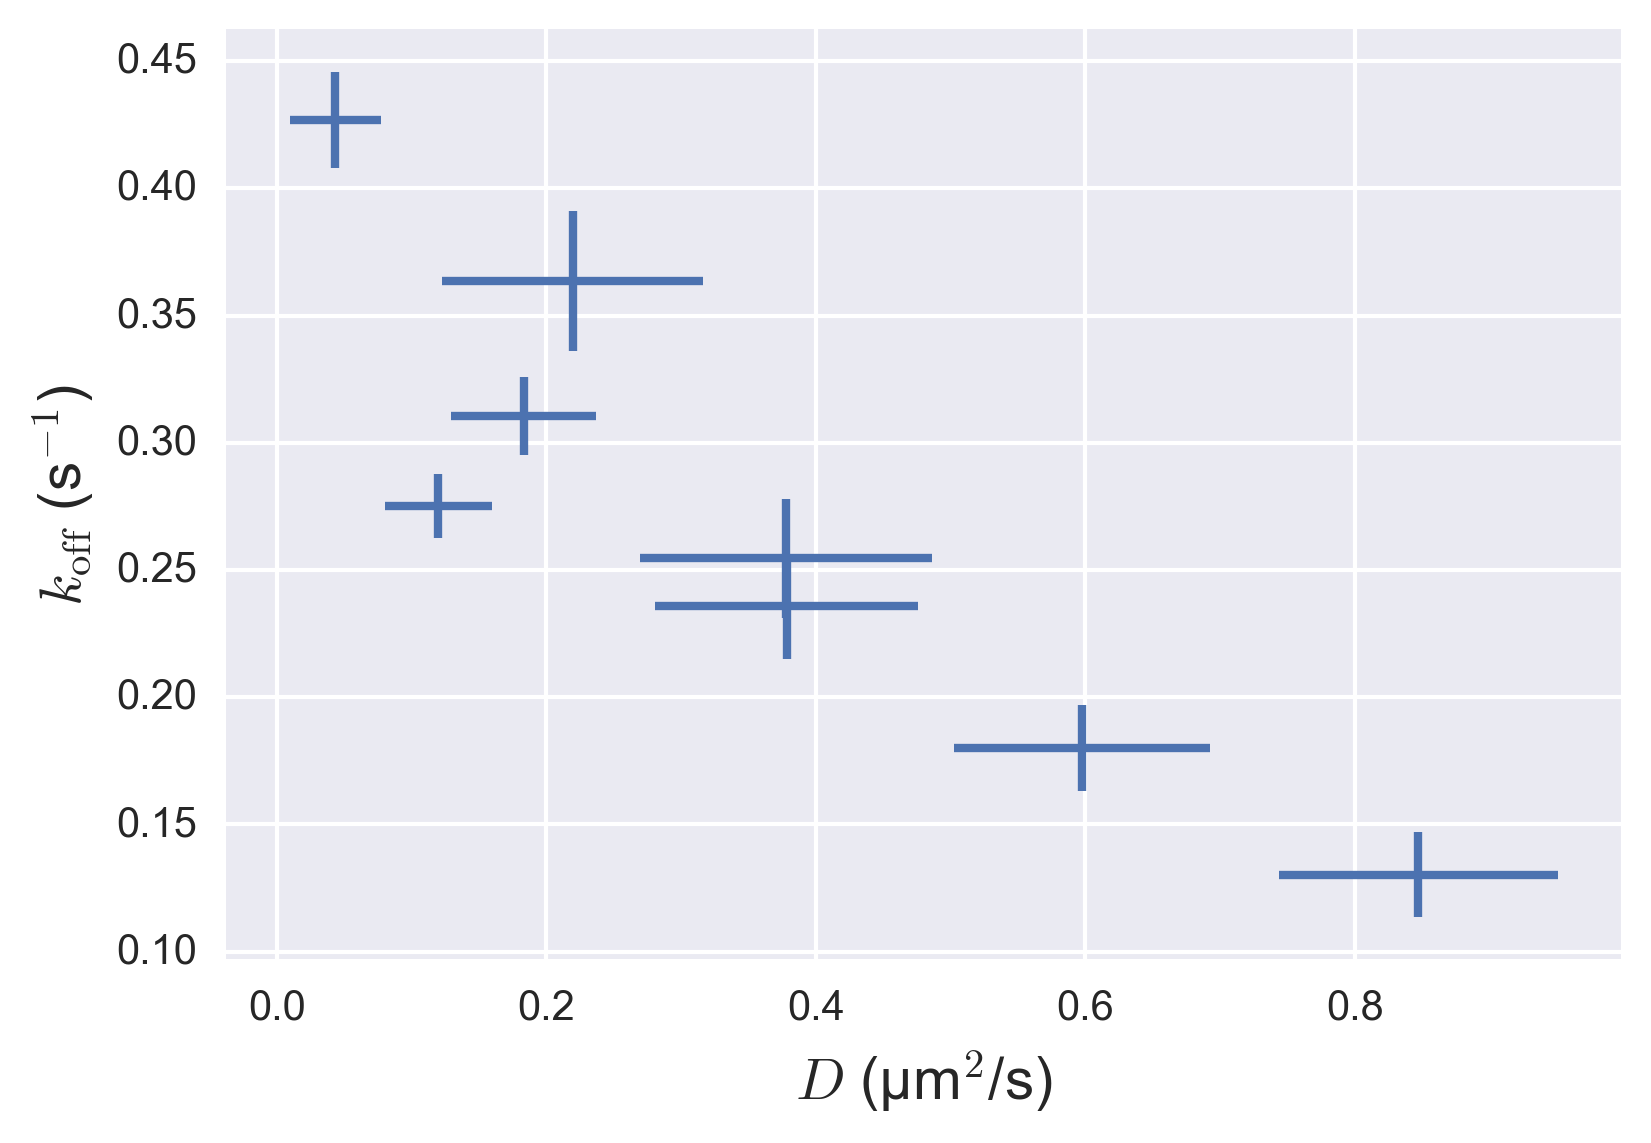

In [87]:
# Plot individual results for k_off and D
plt.errorbar(df_res.D, df_res.k_off, xerr=df_res.D_std, yerr=df_res.k_off_std, 
             markersize=0, fmt='.', color=sns.color_palette()[0], capsize=0)

# Tidy up the plot
plt.margins(0.05)
plt.xlabel('$D$ (µm$^2$/s)')
plt.ylabel(r'$k_\mathrm{off}$ (s$^{-1}$)');

We can check to see how the fits look.

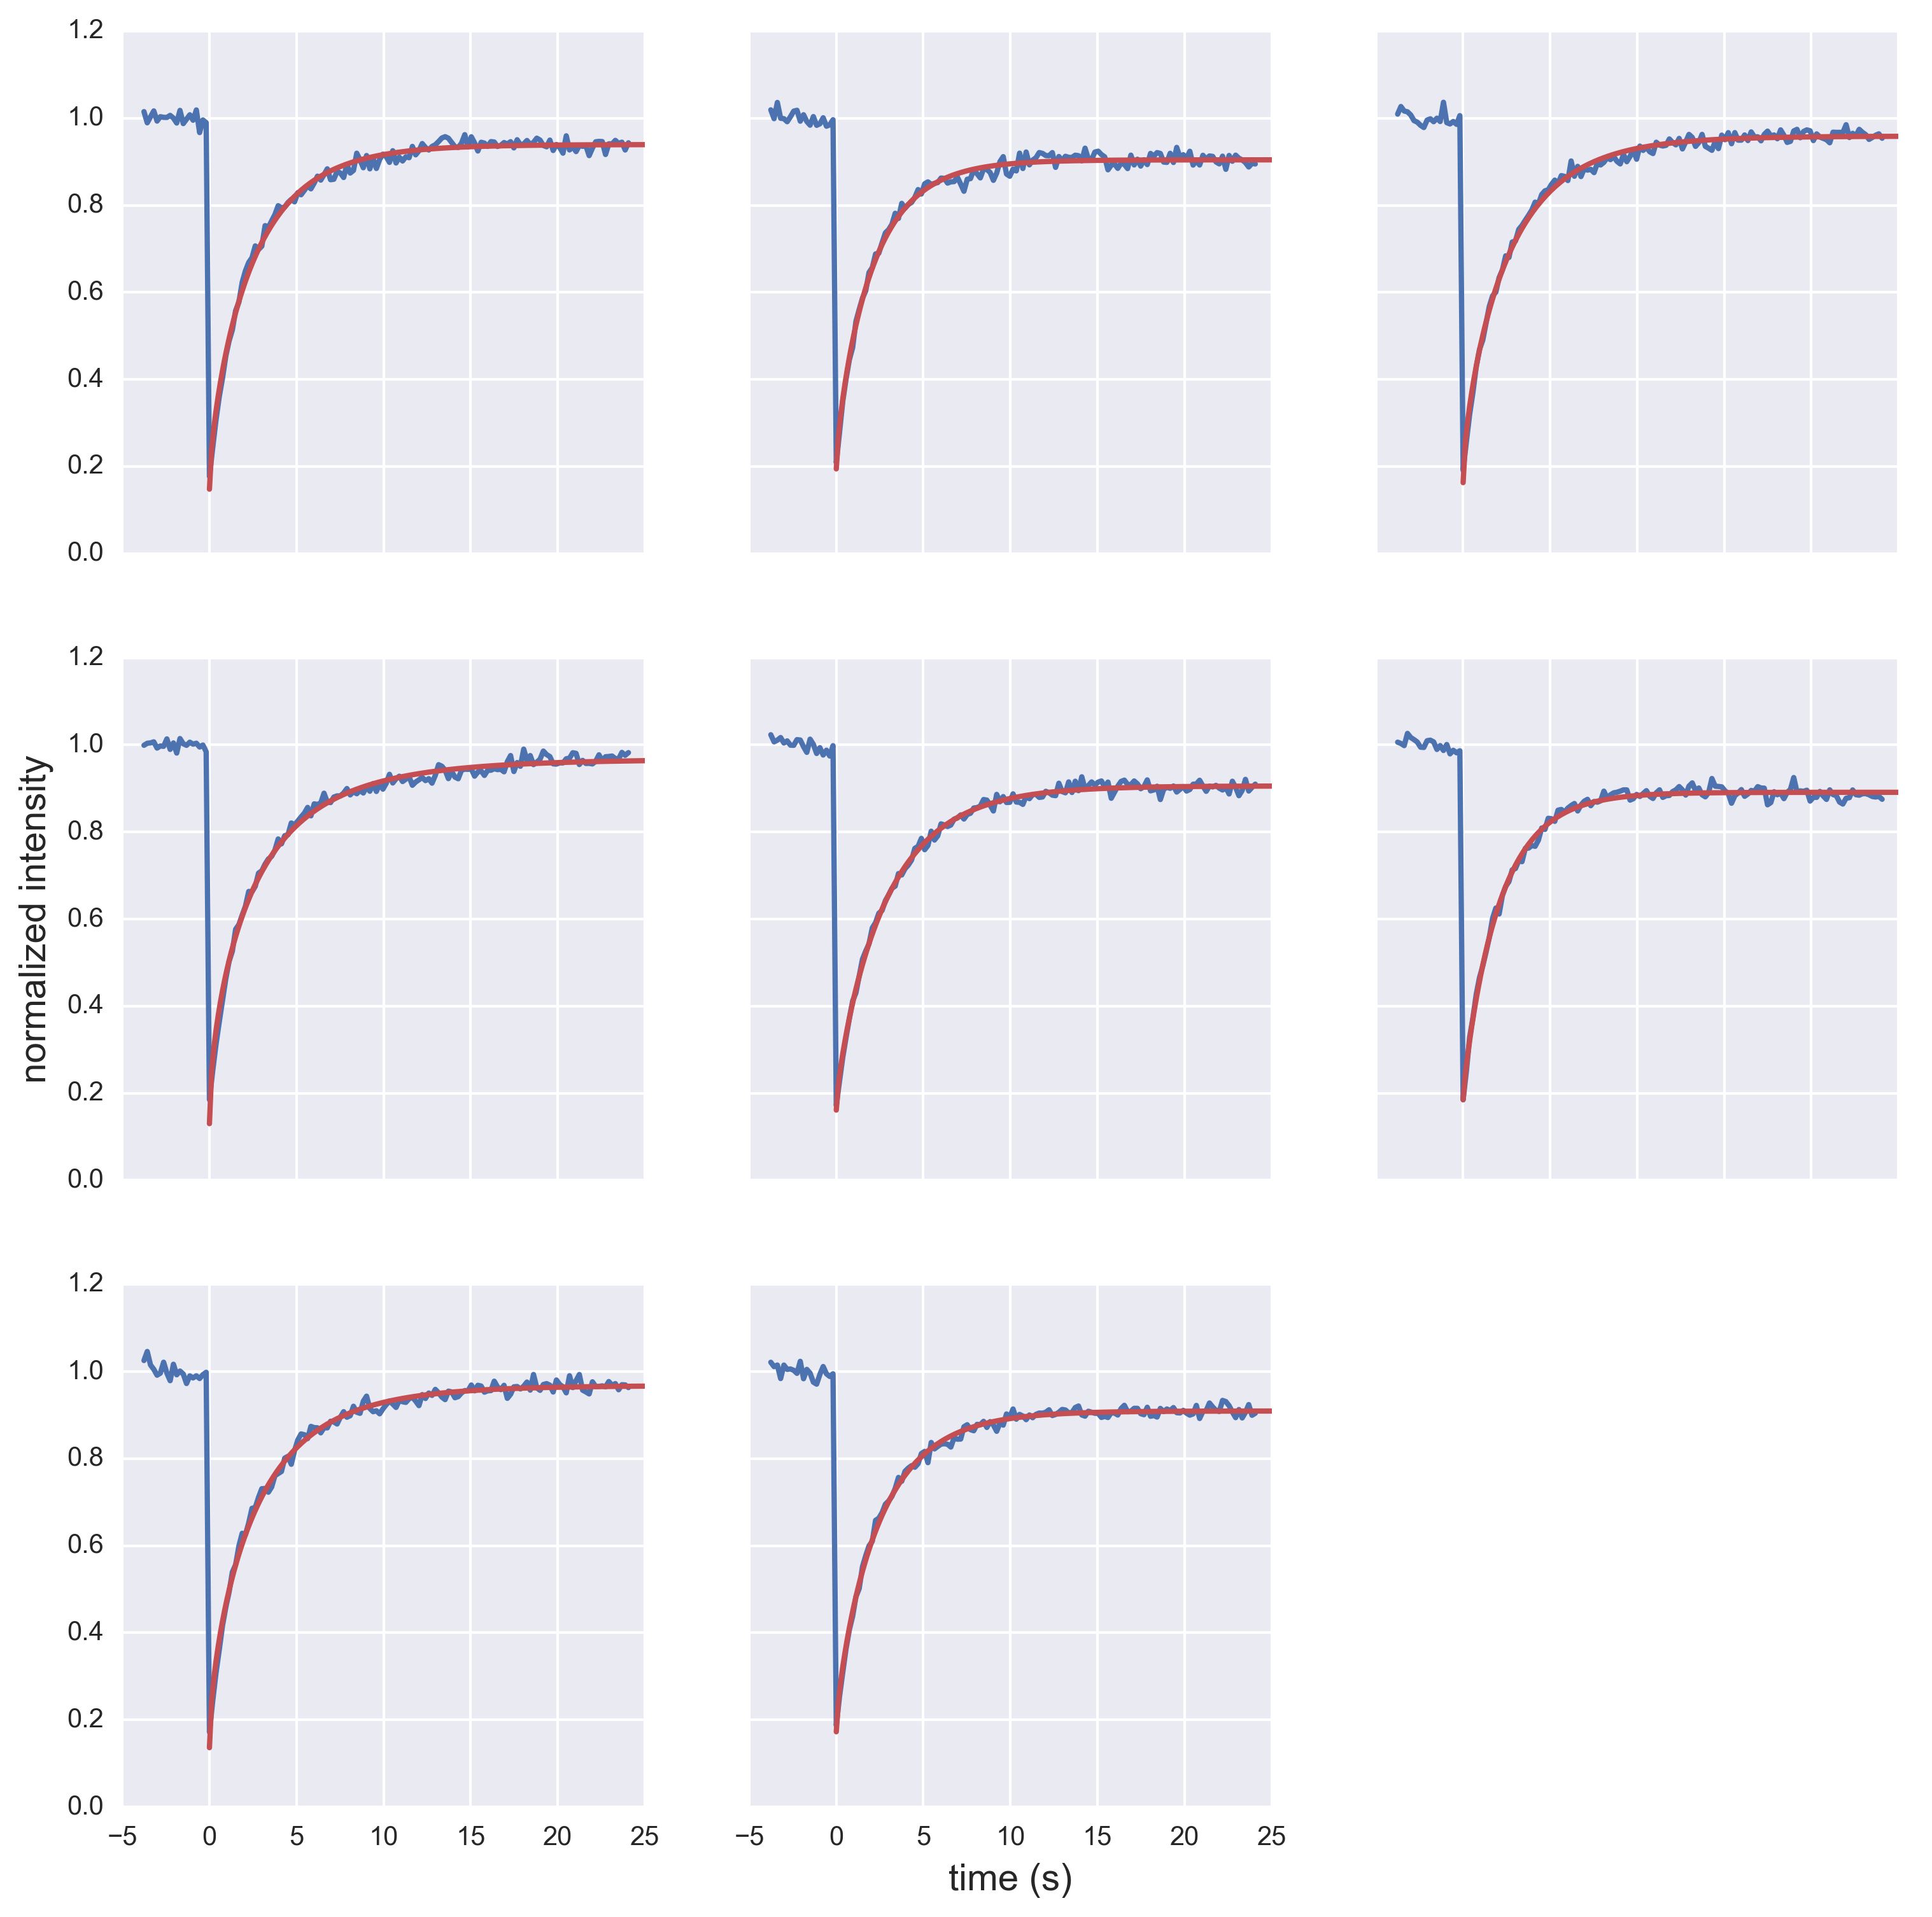

In [72]:
# Set up figure layout
fig, ax = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)

# Convenient indices to have around
inds = list(zip((0, 1, 2, 0, 1, 2, 0, 1, 2), (0, 0, 0, 1, 1, 1, 2, 2, 2)))

# Time points for theoretical curve
t = np.linspace(0, 25, 200)

# Make each plot with fitted curve in red
for i, col in enumerate(df.columns[df.columns.str.contains('normalized')]):
    # Plot experimental curves
    ax[inds[i]].plot(df['time (s)'], df[col], '-')
    
    # Extract parameters from DataFrame and plot smooth curve
    popt = df_res.loc['trial ' + str(i), ['f_f', 'f_b', 'D', 'k_off']].values
    ax[inds[i]].plot(t, norm_fluor_recov(popt, t, dx, dy), 
                     color=sns.color_palette()[2])
    
# Tidy up plot
ax[inds[-1]].axis('off')
ax[2,1].set_xlabel('time (s)')
ax[1,0].set_ylabel('normalized intensity');

We pass the sanity check!

We can now find the estimate for $D$ and $k_\mathrm{off}$ across all samples assuming that each measurement gives a most probable parameter value with an error bar that describes a Gaussian distribution.  We use the formulas we derived in [Homework problem 3.3](http://bebi103.caltech.edu/2016/protected/hw_solutions/hw3_solutions.html#Problem-3.3:-Error-propagation-(10-pts)).

In [73]:
# Extract values of inverse variance
inv_var_D = 1.0 / df_res.D_std**2
inv_var_k_off = 1.0 / df_res.k_off_std**2

# Compute mean and std
D_most_prob = np.dot(df_res.D, inv_var_D) / inv_var_D.sum()
D_error_bar = 1.0 / np.sqrt(inv_var_D.sum())
k_off_most_prob = np.dot(df_res.k_off, inv_var_k_off) / inv_var_k_off.sum()
k_off_error_bar = 1.0 / np.sqrt(inv_var_k_off.sum())

# Print the results
print("""
    D = {0:.3f} +- {1:.3f} µm^2/s
k_off = {2:.3f} +- {3:.3f} 1/s
""".format(D_most_prob, D_error_bar, k_off_most_prob, k_off_error_bar))


    D = 0.177 +- 0.021 µm^2/s
k_off = 0.264 +- 0.006 1/s



We see that the small error bars on the small $D$'s pull the estimate of $D$ leftward.

**c)** Now let's do this with a hierarchical model.  We will assume that $f_f$ and $f_b$ are independent in each experiment, but that the prior for the diffusion coefficient for experiment $i$ is

\begin{align}
P(D_i\mid I) = \frac{1}{\sqrt{2\pi \sigma_D^2}}\,\exp\left[-\frac{(D_i - D)^2}{2\sigma_D^2}\right],
\end{align}

where $D$ is the hyperparameter describing the diffusion coefficient.  Similarly,

\begin{align}
P(k_{\mathrm{off},i}\mid I) = \frac{1}{\sqrt{2\pi \sigma_k^2}}\,\exp\left[-\frac{(k_{\mathrm{off},i} - k_\mathrm{off})^2}{2\sigma_k^2}\right],
\end{align}

where $k_\mathrm{off}$ is the hyperparameter for $k_\mathrm{off}$.  Thus, the likelihood is

\begin{align}
&P(\text{data}\mid \{D_i\}, \{k_{\mathrm{off},i}\}, \{\sigma_i\}, \{f_{f,i}\}, \{f_{b,i}\}) \propto \\[1em]
&\;\;\;\;\;\;\;\;\;\;\;\prod_i\left(
\frac{1}{\sigma_i^{n_i}}\,\exp\left[-\frac{1}{2\sigma_i^2}\sum_j \left(I_{ij}-I_\mathrm{theor}(t_{ij};D_i, k_{\mathrm{off},i},f_{f,i},f_{b,i}\right)^2\right]
\right),
\end{align}

where the index $i$ represents a given embryo (experiment) and the index $j$ represents a data point for that embryo, and $n_i$ is the number of measurements in experiment $i$. The prior is

\begin{align}
&P(\{D_i\}, \{k_{\mathrm{off},i}\}, \{\sigma_i\}, \{f_{f,i}\}, D, k_\mathrm{off}, \sigma_D, \sigma_k) \propto \\[1em]
&\;\;\;\;\;\;\;\;\;\;\;\frac{1}{\sigma_D^{n_\mathrm{exp}+1}\sigma_k^{n_\mathrm{exp}+1}\prod_i\sigma_i}\,\exp\left[- \frac{1}{2\sigma_D^2}\sum_i(D_i - D)^2 - \frac{1}{2\sigma_k^2}\sum_i(k_{\mathrm{off},i} - k_\mathrm{off})^2\right],
\end{align}

where $n_\mathrm{exp}$ is the number of experiments that were done (in our case, 8). We have assumed uniform priors on all parameters except for $\sigma_D$ and $\sigma_k$, which have Jeffreys priors. Let's code up the log prior and log likelihood. 

There are some tricks we need to play here because this is a bit MCMC calculation and we need speed. We cannot use Pandas `DataFrame`s because their access is slow, and functions that use them are not numba-able. We therefore first organize the data into a matrix, where each column is one experiment.

In [89]:
# Get data as NumPy arrays
t = df.loc[bleach_frame:, 'time (s)'].values
traces = df.loc[bleach_frame:, 
                df.columns[df.columns.str.contains('normalized')]].values

Another trick is to have the parameters carefully organized. If we have `n_exp` experiments, we define the ordering of our input parameters in the way they are unpacked.

In [93]:
@numba.jit(nopython=True)
def unpack_params(p, n_exp):
    D = p[0]
    k_off = p[1]
    sigma_D = p[2]
    sigma_k = p[3]
    sigma_vals = p[4:4+n_exp]
    D_vals = p[4+n_exp:4+2*n_exp]
    k_off_vals = p[4+2*n_exp:4+3*n_exp]
    f_b_vals = p[4+3*n_exp:4+4*n_exp]
    f_f_vals = p[4+4*n_exp:]
    return D, k_off, sigma_D, sigma_k, sigma_vals, \
            D_vals, k_off_vals, f_b_vals, f_f_vals

Now, we can code up the likelihood and prior.

In [142]:
@numba.jit(nopython=True)
def log_hier_prior(p, n_exp):
    """
    Log prior of hierarchical model for FRAP experiment.
    """
    # Make sure all parameters are physical
    if (p <= 0).any() or (p[4+3*n_exp:] > 1).any():
        return -np.inf
    
    # Unpack parameters
    D, k_off, sigma_D, sigma_k, sigma_vals, \
            D_vals, k_off_vals, f_b_vals, f_f_vals = unpack_params(p, n_exp)
        
    return -(n_exp+1) * (np.log(sigma_D) + np.log(sigma_k)) \
            - np.sum(np.log(sigma_vals)) \
            - np.sum((D_vals - D)**2) / 2 / sigma_D**2 \
            - np.sum((k_off_vals - k_off)**2) / 2 / sigma_k**2 \


@numba.jit(nopython=True)
def log_hier_like(p, t, traces, dx, dy):
    """
    Log likelihood for hierarchical model.
    """
    # Number of experiments
    n_exp = traces.shape[1]
    
    # Unpack parameters
    D, k_off, sigma_D, sigma_k, sigma_vals, \
            D_vals, k_off_vals, f_b_vals, f_f_vals = unpack_params(p, n_exp)
        
    # Log likelihood is sum of log likes for each experiment
    log_like = 0.0
    for i in range(n_exp):
        args = (t, traces[:,i], dx, dy)
        p_in = np.array([f_b_vals[i], f_f_vals[i], D_vals[i], k_off_vals[i]])
        log_like -= np.sum(resid(p_in, *args)**2) / 2 / sigma_vals[i]**2
        log_like -= len(t) * np.log(sigma_vals[i])

    return log_like


@numba.jit(nopython=True)
def log_hier_post(p, t, traces, dx, dy):
    """
    Log posterior for hierarchical model.
    """
    lp = log_hier_prior(p, traces.shape[1])
    if lp == -np.inf:
        return -np.inf
    return lp + log_hier_like(p, t, traces, dx, dy)

We're now ready to run this beast. Before we start, let's do a quick estimate on how long this might take. How long does it take to evaluate the posterior?

In [144]:
%timeit log_hier_post(p0[0,:], t, traces, dx, dy)

10000 loops, best of 3: 145 µs per loop


So, it it take 145 µs to evaluate the posterior, and we want 300 walkers (we have lots of parameters), that's about 0.05 seconds per step. If we do 5000 burn-in steps and 5000 sampling steps, that's about ten minutes or so.

In [155]:
# Specify experiment parameters
n_exp = df.columns.str.contains('normalized').sum()
n = len(df) - bleach_frame

# Set initial positions of walkers
n_walkers = 300
p0 = np.empty((n_walkers, 4 + 5 * n_exp))
p0[:,0] = np.random.uniform(0.05, 1, n_walkers)   # D
p0[:,1] = np.random.uniform(0.1, 0.5, n_walkers)  # k_off
p0[:,2] = np.random.uniform(0.01, 0.5, n_walkers) # sigma_D
p0[:,3] = np.random.uniform(0.01, 0.5, n_walkers) # sigma_k
p0[:,4:4+n_exp] = np.random.uniform(0.01, 0.1, (n_walkers, n_exp)) # sigma vals
p0[:,4+n_exp:4+2*n_exp] = np.random.uniform(0.05, 1, (n_walkers, n_exp)) # D vals
p0[:,4+2*n_exp:4+3*n_exp] = np.random.uniform(0.1, 0.5, (n_walkers, n_exp))
p0[:,4+3*n_exp:4+4*n_exp] = np.random.uniform(0.0, 1.0, (n_walkers, n_exp))
p0[:,4+4*n_exp:] = np.random.uniform(0.0, 1.0, (n_walkers, n_exp))

# Column headings
cols = ['D', 'k_off', 'sigma_D', 'sigma_k']
cols += ['sigma_' + str(i) for i in range(n_exp)]
cols += ['D_' + str(i) for i in range(n_exp)]
cols += ['k_off_' + str(i) for i in range(n_exp)]
cols += ['f_b_' + str(i) for i in range(n_exp)]
cols += ['f_f_' + str(i) for i in range(n_exp)]

# Perform MCMC
n_burn = 5000
n_steps = 5000
df_mcmc = bebi103.run_ensemble_emcee(
    log_hier_post, n_burn, n_steps, p0=p0, columns=cols,
    args=(t, traces, dx, dy))

Let's make a corner plot of the hyperparameters, which is what we are most interested in.

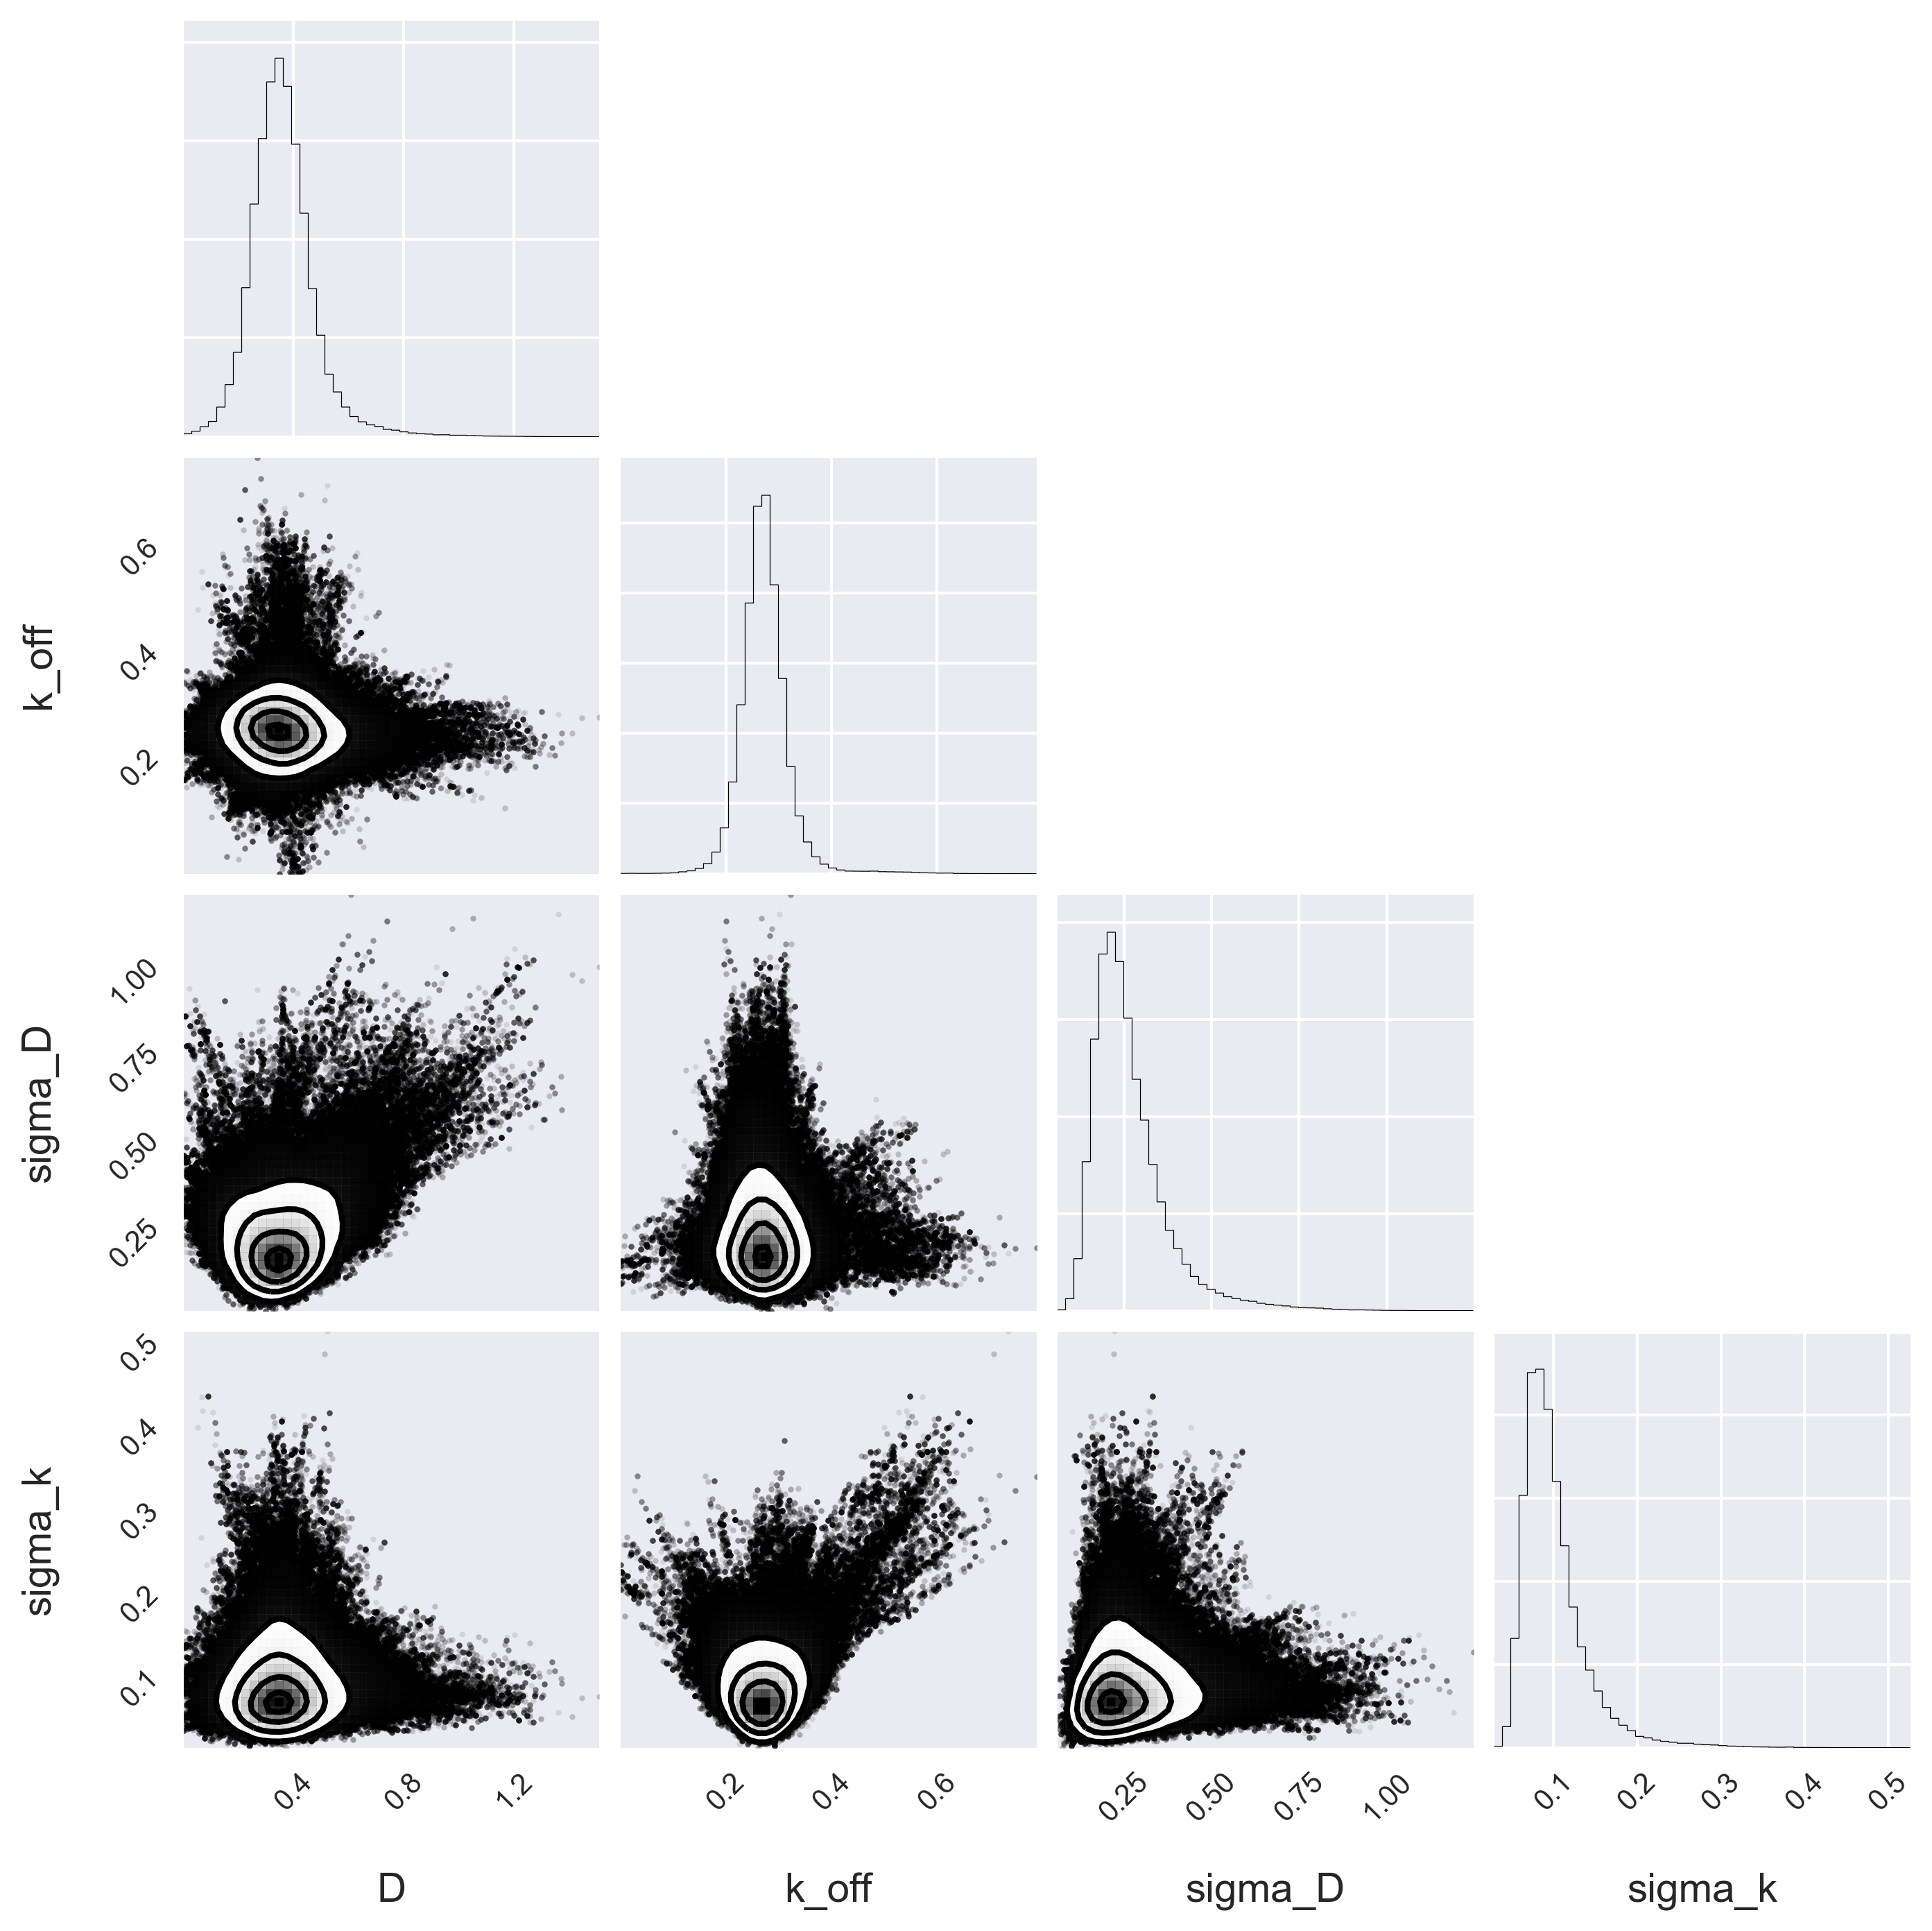

In [156]:
corner.corner(df_mcmc[['D', 'k_off', 'sigma_D', 'sigma_k']], bins=50, smooth=1);

We can compute $D$ and $k_\mathrm{off}$ with mode+HPD.

In [157]:
# Compute MAP and HPD
map_ind = np.argmax(df_mcmc['lnprob'])
hpd_D = bebi103.hpd(df_mcmc['D'], 0.95)
hpd_k_off = bebi103.hpd(df_mcmc['k_off'], 0.95)

# Show results
print("""
D   =   {0:.3f}   {1:.3f}    {2:.3f} µm^2/s
k_off = {3:.3f}   {4:.3f}    {5:.3f} 1/s
""".format(hpd_D[0], df_mcmc['D'][map_ind], hpd_D[1],
          hpd_k_off[0], df_mcmc['k_off'][map_ind], hpd_k_off[1]))


D   =   0.133   0.303    0.593 µm^2/s
k_off = 0.188   0.298    0.357 1/s



We get a similar value for $k_\mathrm{off}$ as we did for the case of doing individual fits, but the value of $D$ is much larger.  The hierarchical model is more immune to the pull of the small measured $D$'s.

We can look at all of the values from the hierarchical model.

In [158]:
df_mcmc.loc[map_ind, :]

D             0.302625
k_off         0.298460
sigma_D       0.198997
sigma_k       0.099010
sigma_0       0.013241
sigma_1       0.014176
sigma_2       0.012511
sigma_3       0.013963
sigma_4       0.010110
sigma_5       0.009343
sigma_6       0.011523
sigma_7       0.011184
D_0           0.440541
D_1           0.672806
D_2           0.560024
D_3           0.235869
D_4           0.155221
D_5           0.249835
D_6           0.339878
D_7           0.053791
k_off_0       0.240902
k_off_1       0.157599
k_off_2       0.188526
k_off_3       0.358173
k_off_4       0.265582
k_off_5       0.290725
k_off_6       0.241611
k_off_7       0.426832
f_b_0         0.849899
f_b_1         0.852400
f_b_2         0.864435
f_b_3         0.786149
f_b_4         0.831199
f_b_5         0.819523
f_b_6         0.824299
f_b_7         0.798702
f_f_0         0.940790
f_f_1         0.963067
f_f_2         0.968596
f_f_3         0.904649
f_f_4         0.906552
f_f_5         0.910598
f_f_6         0.959949
f_f_7      

We can compare the results from the hierarchical model and the individual fits by plotting the most probable parameter values against each other.

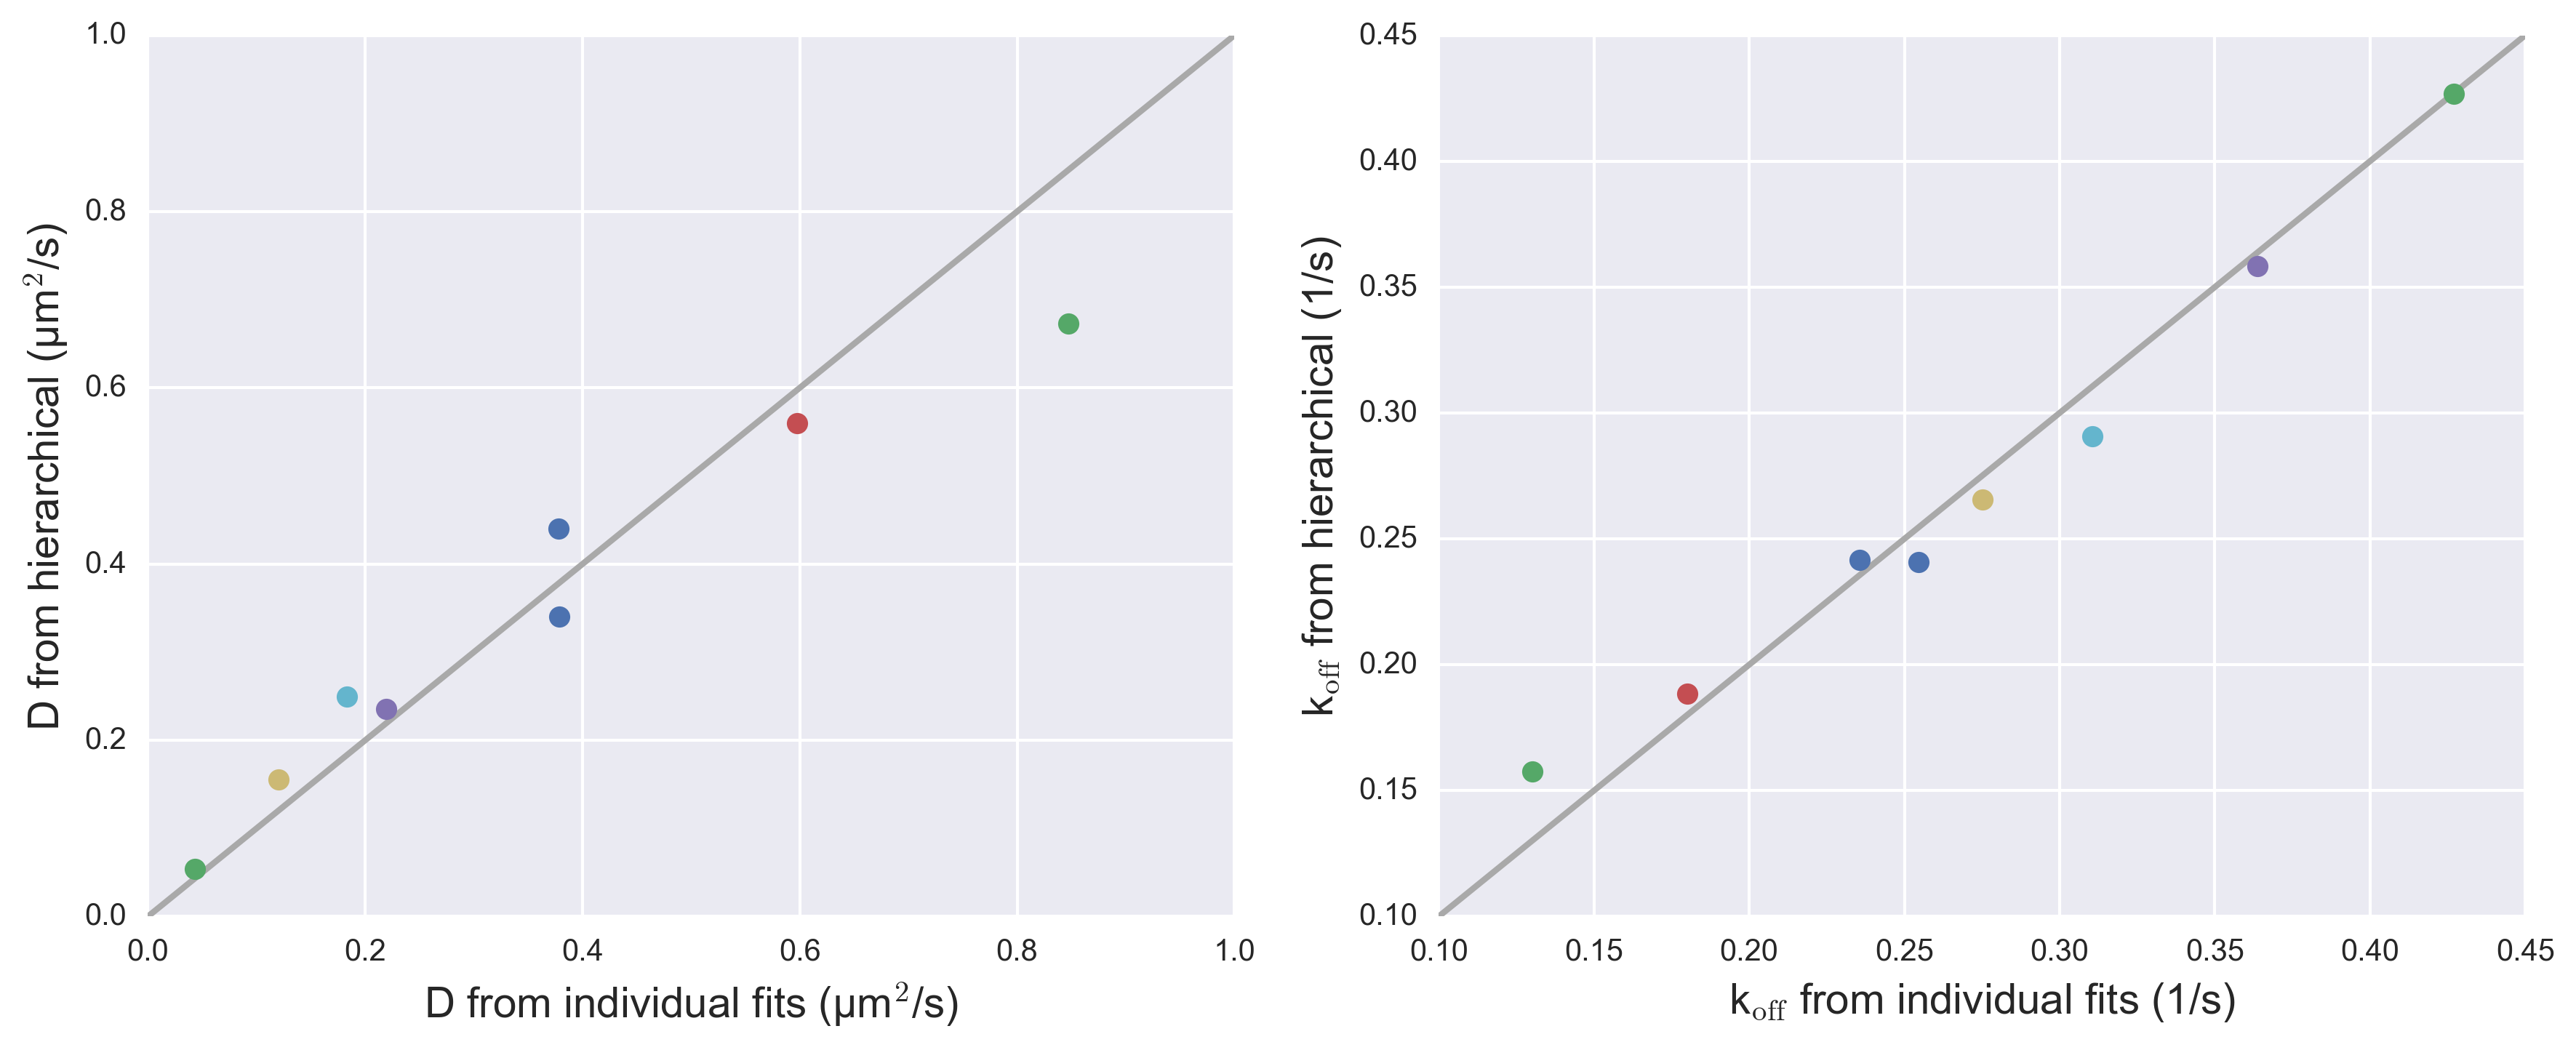

In [159]:
# Set up axes
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot results against each other
with sns.color_palette('Set1', 8):
    for i in range(8):
        ax[0].plot(df_res['D'][i], df_mcmc.loc[map_ind, 'D_' + str(i)], 
                   'o', zorder=2)
        ax[1].plot(df_res['k_off'][i], 
                   df_mcmc.loc[map_ind, 'k_off_' + str(i)], 'o', zorder=2)

# Diagonal line for equality
ax[0].plot([0, 1], [0, 1], '-', color='darkgray', zorder=1)
ax[1].plot([0.1, 0.45], [0.1, 0.45], '-', color='darkgray', zorder=1)

# Label
ax[0].set_xlabel('D from individual fits (µm$^2$/s)')
ax[0].set_ylabel('D from hierarchical (µm$^2$/s)')
ax[1].set_xlabel(r'k$_\mathrm{off}$ from individual fits (1/s)')
ax[1].set_ylabel(r'k$_\mathrm{off}$ from hierarchical (1/s)')

plt.tight_layout()

As we can see, the results from individual fits are close to those from the hierarchical model. An exception is for fast diffusion, shown by the green dot.

Finally, the parameters $\sigma_D$ and $\sigma_k$ tell us how much we can expect the diffusion coefficient and $k_\mathrm{off}$ to vary from experiment to experiment.  We got the most probable values to be $\sigma_D = 0.2$ µm$^2$/s and $\sigma_k = 0.1$ s$^{-1}$.  This suggests that $D$ can vary pretty wildly from experiment to experiment, as its most probable value is close to that of $\sigma_D$.